![YouTube Logo](./images/20240322_1525_youtube.jpg)

**Step 1: Understanding the problem**

We are marketing company specialized in providing consultancy to content creators

We could predict with high accuracy which keywords are the more successful ones predicting total views

Data source is from

https://www.kaggle.com/datasets/asaniczka/2024-youtube-channels-1-million


**Step 2: Importing libraries and customized functions**

In [58]:
import ast  # Module for literal_eval
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
#import joblib
import pickle

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler,MultiLabelBinarizer,OneHotEncoder,OrdinalEncoder,StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import tensorflow as tf
from tensorflow.keras import regularizers
from xgboost import XGBRegressor
#customized functions

import scripts.bootcampviztools as bc
import scripts.data_functions as dafu
import scripts.toolbox_ML as tb






**Step 3: Importing data**

As Github does not allow >100 Megabytes file, data is compressed in 7zip format in blocks of 95 Megabytes

It checks if CSV file already exists

In [2]:
try:
    import zipfile
    print("zipfile is already installed.")
except ImportError:
    print("zipfile not found. Installing...")
    %pip install zipfile

zipfile is already installed.


In [3]:
csv_relative_path ="./data/youtube/youtube_channels_1M_clean.csv"



Decompressing ZIP multipart archive in ./data/youtube

In [4]:
if os.path.exists(csv_relative_path)==False:
    # Relative path or file name
    relative_path = 'data/youtube/'
    archive_name='youtube_channels_1M_clean.zip'
    zip_prefix = "youtube_channels_1M_clean.zip."
    # Get the current working directory
    cwd = os.getcwd()

    # Combine them to form a full path
    full_archive_path = os.path.join(cwd, relative_path).replace("\\","/")
    full_archive_path = os.path.join(full_archive_path, archive_name).replace("\\","/")
    full_zip_prefix = os.path.join(cwd, relative_path).replace("\\","/")
    full_zip_prefix = os.path.join(full_zip_prefix, zip_prefix).replace("\\","/")
    full_output_path = os.path.join(cwd, relative_path).replace("\\","/")



    # Output directory where the files will be extracted
    output_directory = './data/youtube/'

    # N number of parts
    import glob

    parts = glob.glob(full_zip_prefix + '*')
    for index,part in enumerate(parts):
        parts[index]=part.replace("\\","/")
    n = len(parts)
    # Concatenate
    with open(full_archive_path , "wb") as outfile:
        for i in range(1, n+1):
            filename = full_zip_prefix + str(i).zfill(3)
            with open(filename, "rb") as infile:
                outfile.write(infile.read())

    #Extract
    with zipfile.ZipFile(full_archive_path, "r") as zip_ref:
        zip_ref.extractall(full_output_path)

    print("Extraction complete!")

In [5]:
# Reading CSV 
file_path = './data/youtube/youtube_channels_1M_clean.csv'
df = pd.read_csv(file_path)


Before cleaning data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095242 entries, 0 to 1095241
Data columns (total 16 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   channel_id                   1095242 non-null  object 
 1   channel_link                 1095242 non-null  object 
 2   channel_name                 1095182 non-null  object 
 3   subscriber_count             1095242 non-null  int64  
 4   banner_link                  766877 non-null   object 
 5   description                  819743 non-null   object 
 6   keywords                     547203 non-null   object 
 7   avatar                       1095242 non-null  object 
 8   country                      620059 non-null   object 
 9   total_views                  1094490 non-null  float64
 10  total_videos                 1094985 non-null  float64
 11  join_date                    1095220 non-null  object 
 12  mean_views_last_30_videos    1059085 non-n

Filtering data to get a clean DataFrame 

filtering by Countries and that are null

In [7]:

df_filtered_1 = df[df[['country']].notna().all(axis=1)].copy()

df_filtered_2 =df_filtered_1[df_filtered_1[['keywords']].notna().all(axis=1)].copy()
df_filtered_3 =df_filtered_2[df_filtered_2['subscriber_count']>0].copy()
df_filtered_4 =df_filtered_3[df_filtered_3[['total_views']].notna().all(axis=1)].copy()
df_filtered_5=df_filtered_4[df_filtered_4[['description']].notna().all(axis=1)].copy()
df_filtered_5=df_filtered_5[df_filtered_5['videos_per_week']>0].copy()
df_filtered_backup=df_filtered_5.copy()
df=df_filtered_5

After cleaning data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183514 entries, 3 to 1095226
Data columns (total 16 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   channel_id                   183514 non-null  object 
 1   channel_link                 183514 non-null  object 
 2   channel_name                 183504 non-null  object 
 3   subscriber_count             183514 non-null  int64  
 4   banner_link                  173351 non-null  object 
 5   description                  183514 non-null  object 
 6   keywords                     183514 non-null  object 
 7   avatar                       183514 non-null  object 
 8   country                      183514 non-null  object 
 9   total_views                  183514 non-null  float64
 10  total_videos                 183514 non-null  float64
 11  join_date                    183513 non-null  object 
 12  mean_views_last_30_videos    183514 non-null  float64
 13  med

**Step 4: Dataset explanation**

https://www.kaggle.com/datasets/asaniczka/2024-youtube-channels-1-million

This dataset contains information on 1 million (plus a bit more) YouTube channels. Channels were picked randomly to extract data.

It includes insights into subscriber counts, total views, total videos, engagement statistics, and more.

I've added some aggregated data about videos of each channel as well.

**Dataset:**  youtube_channels_1M_clean.csv  

**Description:** This dataset contains information on 0 million (plus a bit more) YouTube channels. Channels were picked randomly to extract data.

It includes insights into subscriber counts, total views, total videos, engagement statistics, and more.

It has been added some aggregated data about videos of each channel as well.

**Period:**  From 02/05/2005 to 09/03/2024

<h0>df</h0>
<table>
<tr><th>Column/Variable</th><th>Description</th><th>Variable type</th><th>Importance</th><th>Note</th></tr>
<tr><td>channel_id</td><td>Unique ID assigned to each YouTube channel. (type:str)</td><td>object</td><td>0</td><td></td></tr>
<tr><td>channel_link</td><td>Link to the YouTube channel. (type:str)</td><td>object</td><td>0</td><td></td></tr>
<tr><td>channel_name</td><td>Name of the YouTube channel. (type:str)</td><td>object</td><td>0</td><td></td></tr>
<tr><td>subscriber_count</td><td>Number of subscribers the channel has. (type:int)</td><td>int</td><td>1</td><td></td></tr>
<tr><td>banner_link</td><td>Link to the channel's banner image. (type:str)</td><td>object</td><td>0</td><td></td></tr>
<tr><td>description</td><td>Brief description of the channel. (type:str)</td><td>object</td><td>0</td><td></td></tr>
<tr><td>keywords</td><td>Keywords associated with the channel's content. Do .split(", ") to convert to a list (type:str)</td><td>object</td><td>1</td><td></td></tr>
<tr><td>avatar</td><td>Link to the channel's avatar image. (type:str)</td><td>object</td><td>0</td><td></td></tr>
<tr><td>country</td><td>Country of the YouTuber</td><td>object</td><td>1</td><td></td></tr>
<tr><td>total_views</td><td>Total number of views the channel has received. (type:float)</td><td>float</td><td>1</td><td>Target of the model</td></tr>
<tr><td>total_videos</td><td>Total number of videos of the channel. (type:float)</td><td>float</td><td>1</td><td></td></tr>
<tr><td>join_date</td><td>Date when YouTube Channel was created</td><td>object</td><td>1</td><td></td></tr>
<tr><td>mean_views_last_30_videos</td><td>Mean views of last 30 videos</td><td>float</td><td>1</td><td></td></tr>
<tr><td>median_views_last_30_videos</td><td>Median views of last 30 videos</td><td>object</td><td>1</td><td></td></tr>
<tr><td>std_views_last_30_videos</td><td>Standard views of last 30 videos</td><td>object</td><td>1</td><td></td></tr>
<tr><td>videos_per_week</td><td>Number of videos uploaded per week</td><td>object</td><td>1</td><td></td></tr>
</table>

**Step 5: Visualizing data and EDA**

Defining Target variable

In [9]:
target="total_views"


Presenting 10 records

In [10]:
df.head(10)


channel_id              channel_link  \
3   UCAQOeJwsgBMC74-OjjcQcJA      /@JerryAndJulieMusic   
9   UCWTnzxJ58oAfydJ_0Fgm6fg   /@yourshealthbeauty7219   
15  UCoX36PeEA0NYJ5tCl4YDPYw             /@TheAntwiwaa   
16  UCl1PIKAnK7Q53KVBudhg54Q  /@DrMichaelsDentalClinic   
23  UCc-N24Y5OA0gqbjBwe1ttfA            /@WeirdHistory   
24  UC9qgVkKRZUXcgHdf35Z-8dw    /@MyLittlePonyOfficial   
26  UCQXKj_Nl1FRBRHRmama6_rw     /@nabahatskitchen3566   
43  UCUz1YxdzDB5s_vmaq5L1mXQ            /@jessiraeyoga   
46  UCmRY4NSGK52lP_Lz11CjdYw                /@VyQwaint   
58  UC5kFNaPfZ-ilbaJA5d-djnw  /@JubilantJulietsKitchen   

                   channel_name  subscriber_count  \
3           Jerry & Julie Music              1090   
9         Yours Health & Beauty              1380   
15                 The Antwiwaa             20900   
16  Dr. Michael's Dental Clinic             11200   
23                Weird History           4420000   
24      My Little Pony Official           5200000   
26            Nabahat's Kitchen              1120   
43               Jessi Rae Yoga             10000   
46                    Vy Qwaint          11700000   
58    Jubilant Juliet's Kitchen              1450   

                                          banner_link  \
3   https://yt3.googleusercontent.com/dI6Oq0iOhx-c...   
9   https://yt3.googleusercontent.com/0C9r0JCPlFP3...   
15  https://yt3.googleusercontent.com/0Pv02_bXlrxX...   
16  https://yt3.googleusercontent.com/GMQtvVYhluJU...   
23  https://yt3.googleusercontent.com/ch1dKorOrP9C...   
24  https://yt3.googleusercontent.com/1suA06oSD-Cz...   
26  https://yt3.googleusercontent.com/wZGbUiqF5KS9...   
43  https://yt3.googleusercontent.com/XR9J9TH5-hGs...   
46  https://yt3.googleusercontent.com/fwOzkmFf8Wwe...   
58  https://yt3.googleusercontent.com/cqlwYaxELjIO...   

                                          description  \
3   Welcome to Jerry & Julie Music.  We hope you w...   
9   Hey beautiful and special people's I share ver...   
15  Dairy of a young woman figuring out life, her ...   
16  Dr. Michael's Dental Clinic is your one-stop s...   
23  Welcome to the chronicles of history that was ...   
24  Welcome everypony 🦄  to the official home of M...   
26  Hello friends ....\n\nWelcome to the Nabahat's...   
43  Jessi Rae is an internationally known yoga ins...   
46  Hi, my name is Vy! My husband Chad Wild Clay a...   
58  \n\nHello, my name is Juliet\nWelcome to my ch...   

                                             keywords  \
3   jerryandjuliemusic, jerryspianobar, juliesguit...   
9                 Health, Beauty, Tips, Food, Fashion   
15  financial literacy, personal growth, personal ...   
16  dental, dentist, dental clinic, orthodontist, ...   
23  weird history, historical facts, history, hist...   
24  my little pony, pony, little pony, my little p...   
26  recipes for beginners, cupcakes ideas, eggless...   
43  jessi rae yoga, yoga, wild roots yoga, jessi r...   
46  fashion, how-to, lifestyle, beauty, hairstyle,...   
58  Healthy meal recipes, How to cook, Quick meal ...   

                                               avatar               country  \
3   https://yt3.googleusercontent.com/c41pe3_aA75h...         United States   
9   https://yt3.googleusercontent.com/ytc/AIdro_mI...              Pakistan   
15  https://yt3.googleusercontent.com/GE8vh-EJlPiT...        United Kingdom   
16  https://yt3.googleusercontent.com/ytc/AIdro_kv...  United Arab Emirates   
23  https://yt3.googleusercontent.com/UIPjlpb2xPE6...         United States   
24  https://yt3.googleusercontent.com/s4raSN25tWZb...         United States   
26  https://yt3.googleusercontent.com/hEvMvh8OWEj_...        United Kingdom   
43  https://yt3.googleusercontent.com/aT7FYA5nOzrg...         United States   
46  https://yt3.googleusercontent.com/8cahxhV_ZXGk...         United States   
58  https://yt3.googleusercontent.com/KwXjUpKQR9EQ...        United Kingdom   

     total_views  total_videos   join_dat

In [11]:
df.describe()


subscriber_count   total_views  total_videos  \
count      1.835140e+05  1.835140e+05  1.835140e+05   
mean       2.300656e+05  8.730981e+07  1.134137e+03   
std        1.721406e+06  1.109565e+09  7.253132e+03   
min        1.000000e+00  1.000000e+00  1.000000e+00   
25%        1.020000e+03  1.418332e+05  1.410000e+02   
50%        5.130000e+03  8.696430e+05  3.380000e+02   
75%        4.560000e+04  8.665082e+06  7.860000e+02   
max        2.440000e+08  1.788442e+11  1.248360e+06   

       mean_views_last_30_videos  median_views_last_30_videos  \
count               1.835140e+05                 1.835140e+05   
mean                4.479401e+04                 2.456732e+04   
std                 7.319309e+05                 5.512873e+05   
min                 0.000000e+00                 0.000000e+00   
25%                 1.722000e+02                 7.700000e+01   
50%                 8.914667e+02                 3.430000e+02   
75%                 6.174533e+03                 2.502000e+03   
max                 1.971791e+08                 1.783875e+08   

       std_views_last_30_videos  videos_per_week  
count              1.835140e+05    183514.000000  
mean               6.278170e+04         2.072691  
std                9.266876e+05         2.222977  
min                0.000000e+00         0.250000  
25%                1.967494e+02         0.500000  
50%                1.113299e+03         1.000000  
75%                8.560953e+03         2.750000  
max                1.613799e+08         7.500000

Visualizing data in a graph

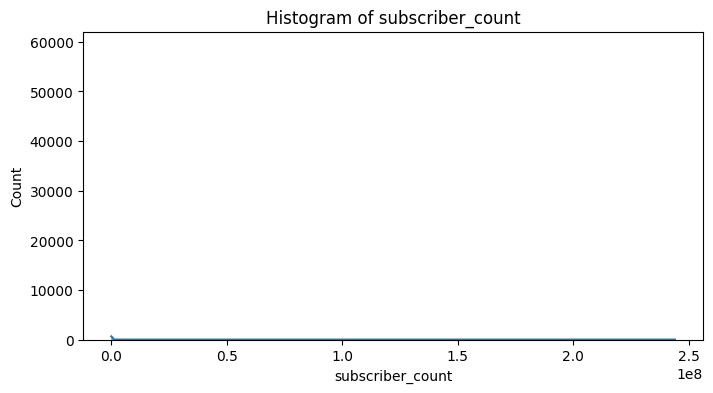

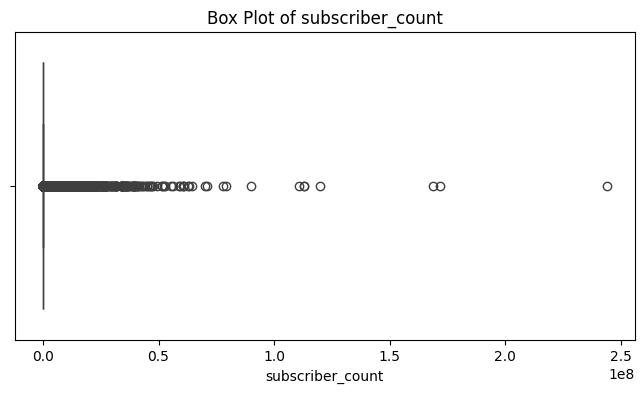

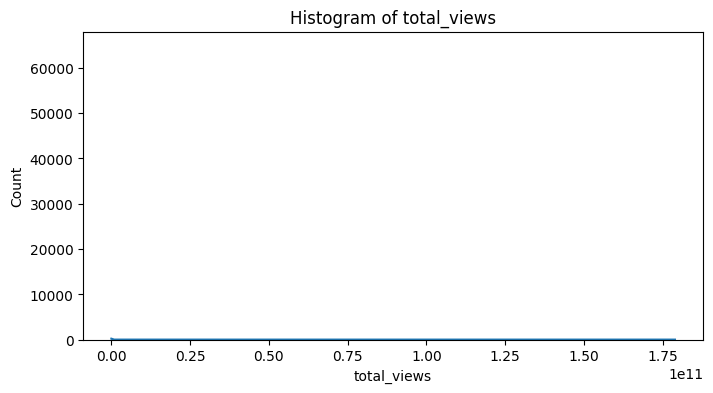

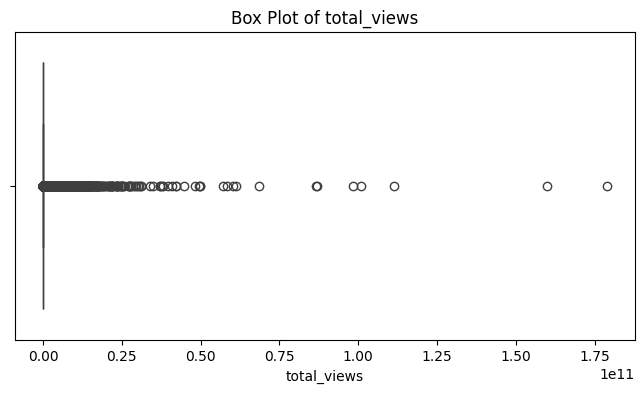

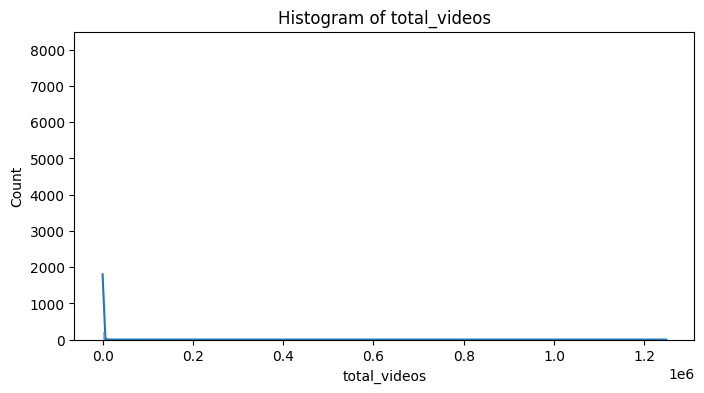

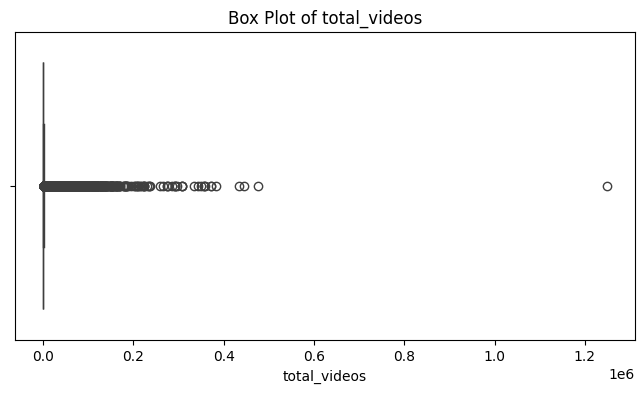

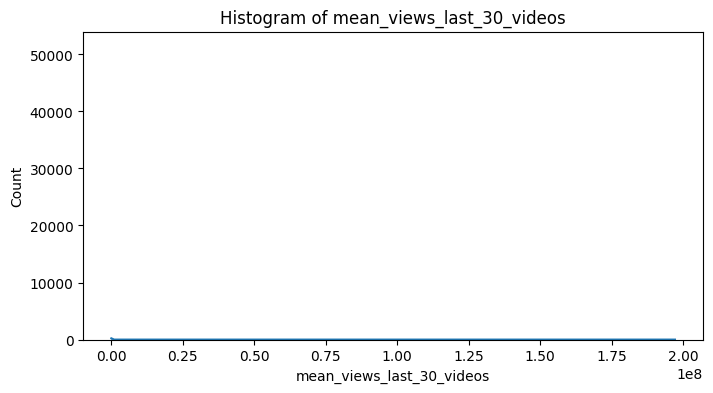

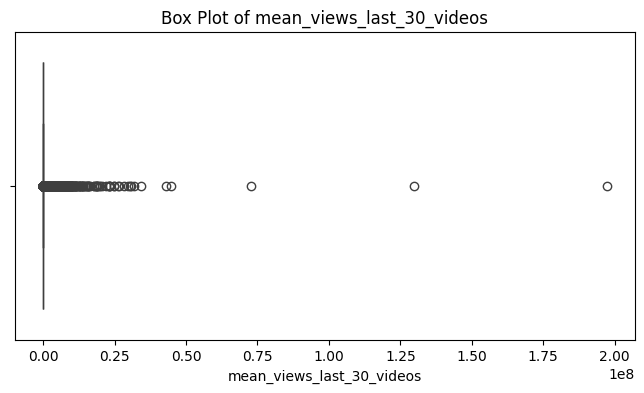

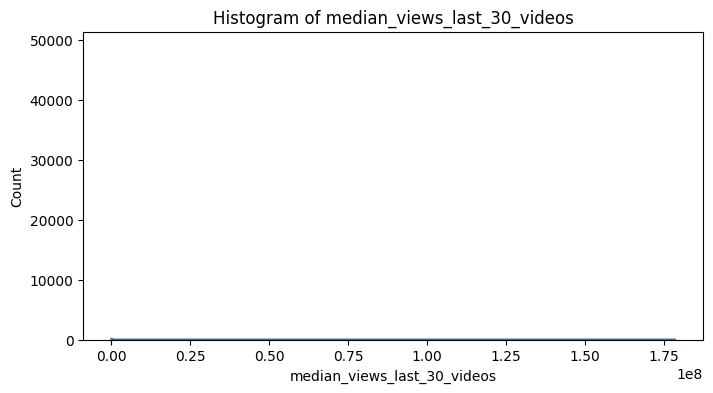

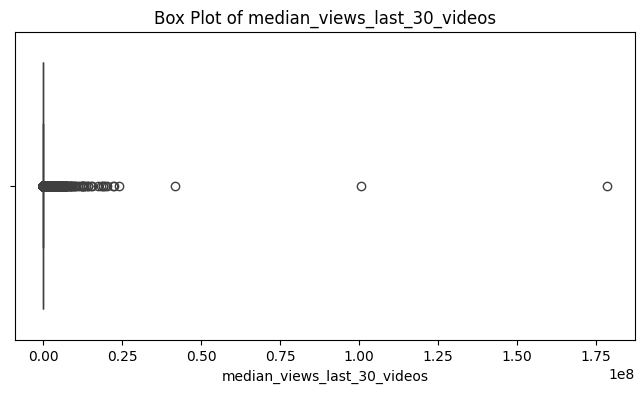

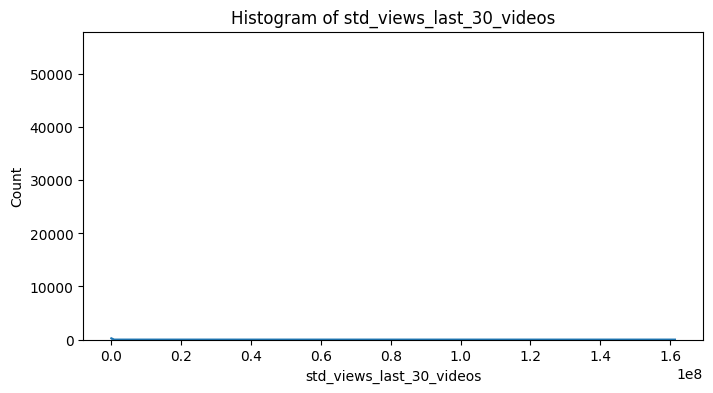

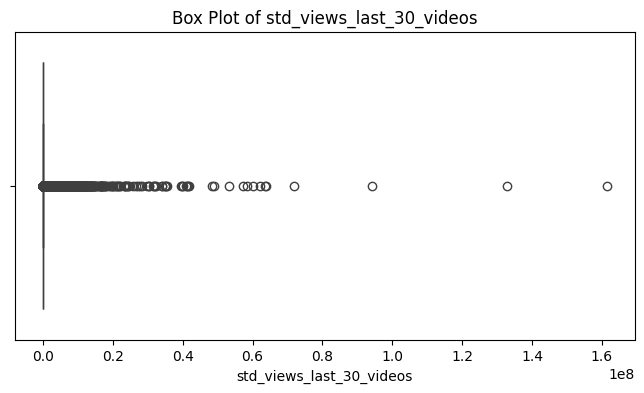

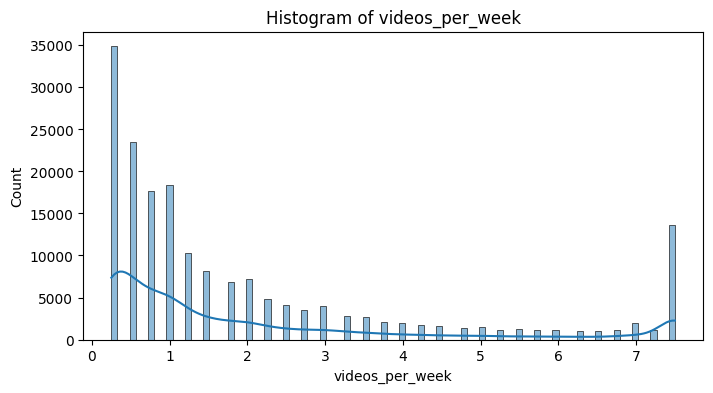

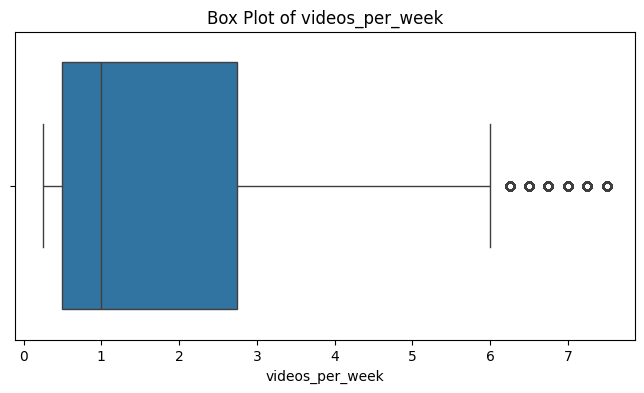

<module 'matplotlib.pyplot' from 'c:\\Users\\Jorge\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [12]:
dafu.eda1_num(df,target,df.select_dtypes(include=['float64', 'int64']).columns)

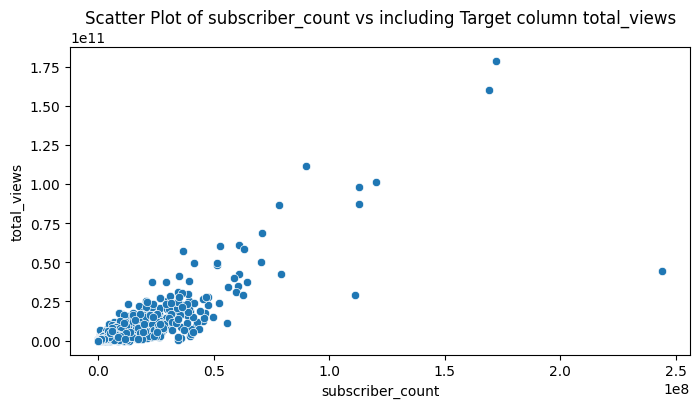

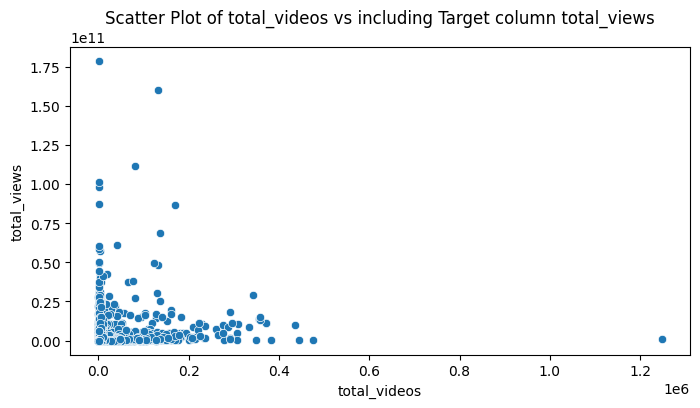

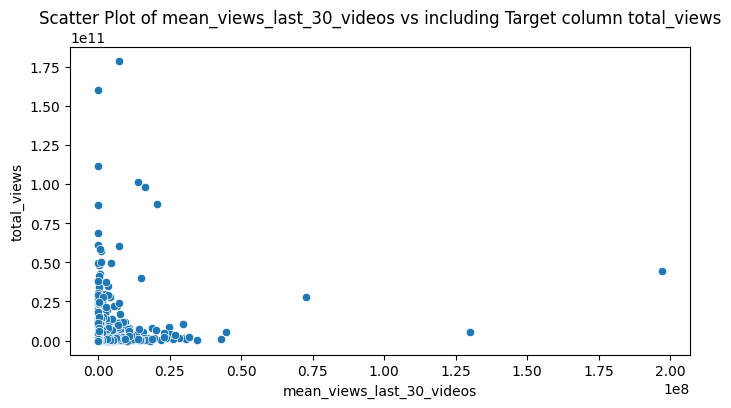

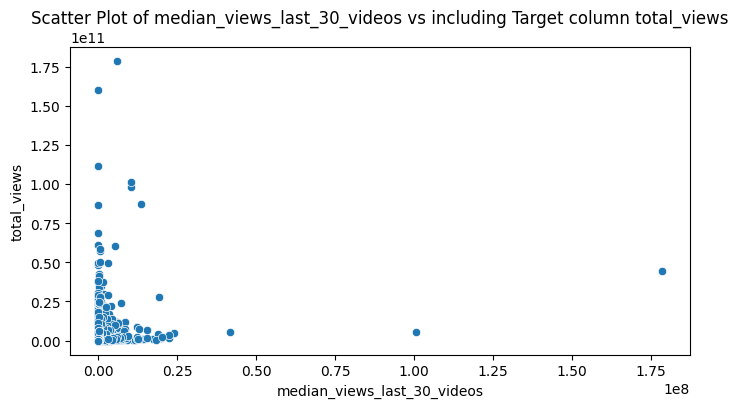

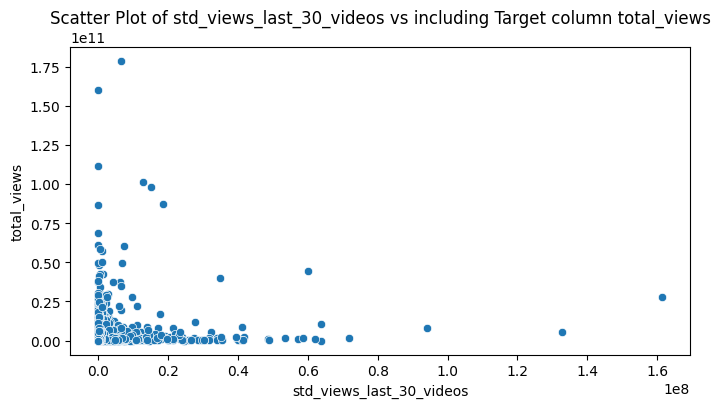

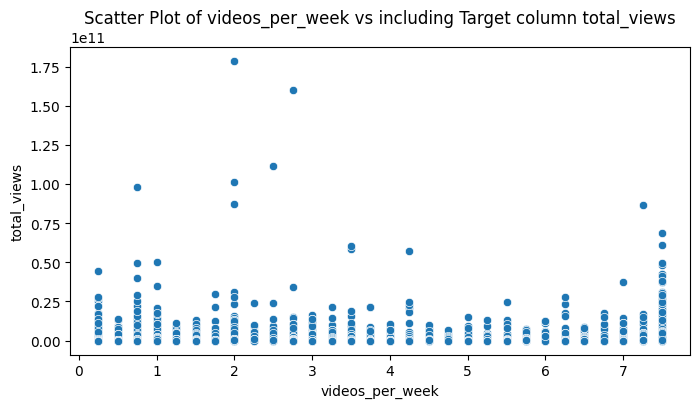

<module 'matplotlib.pyplot' from 'c:\\Users\\Jorge\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [13]:

dafu.eda2_num(df,target,df.select_dtypes(include=['float64', 'int64']).columns)

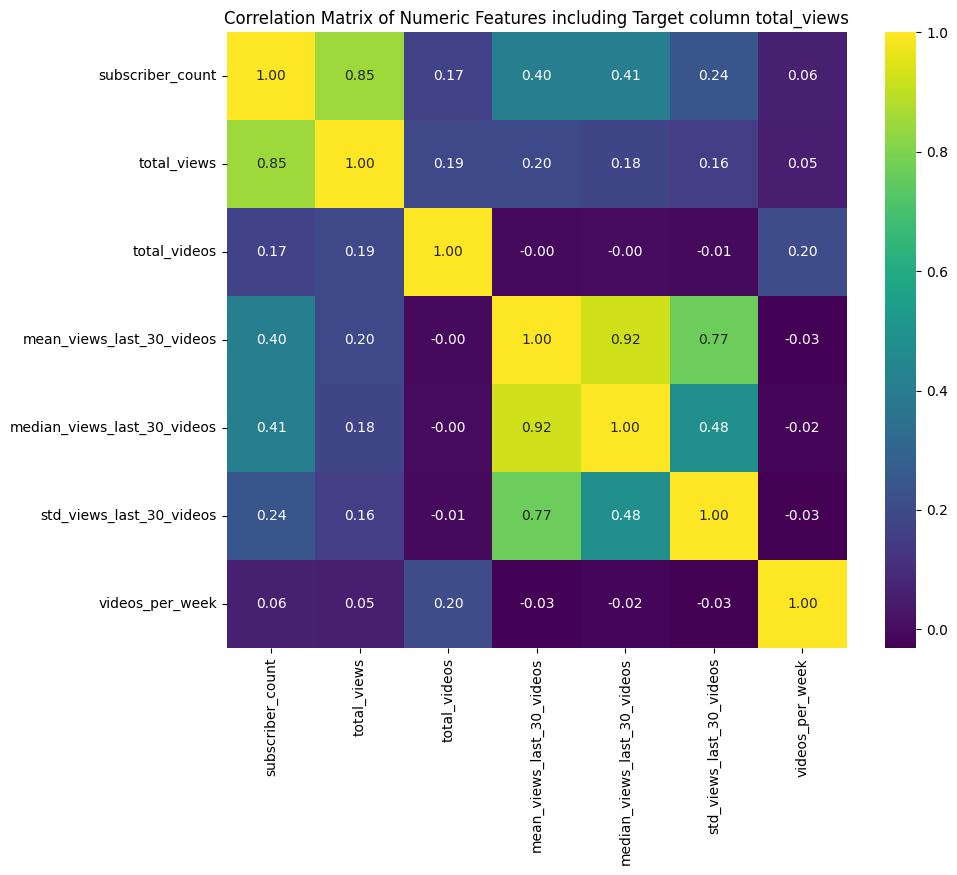

<module 'matplotlib.pyplot' from 'c:\\Users\\Jorge\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [14]:

dafu.eda3_num(df,target,df.select_dtypes(include=['float64', 'int64']).columns)

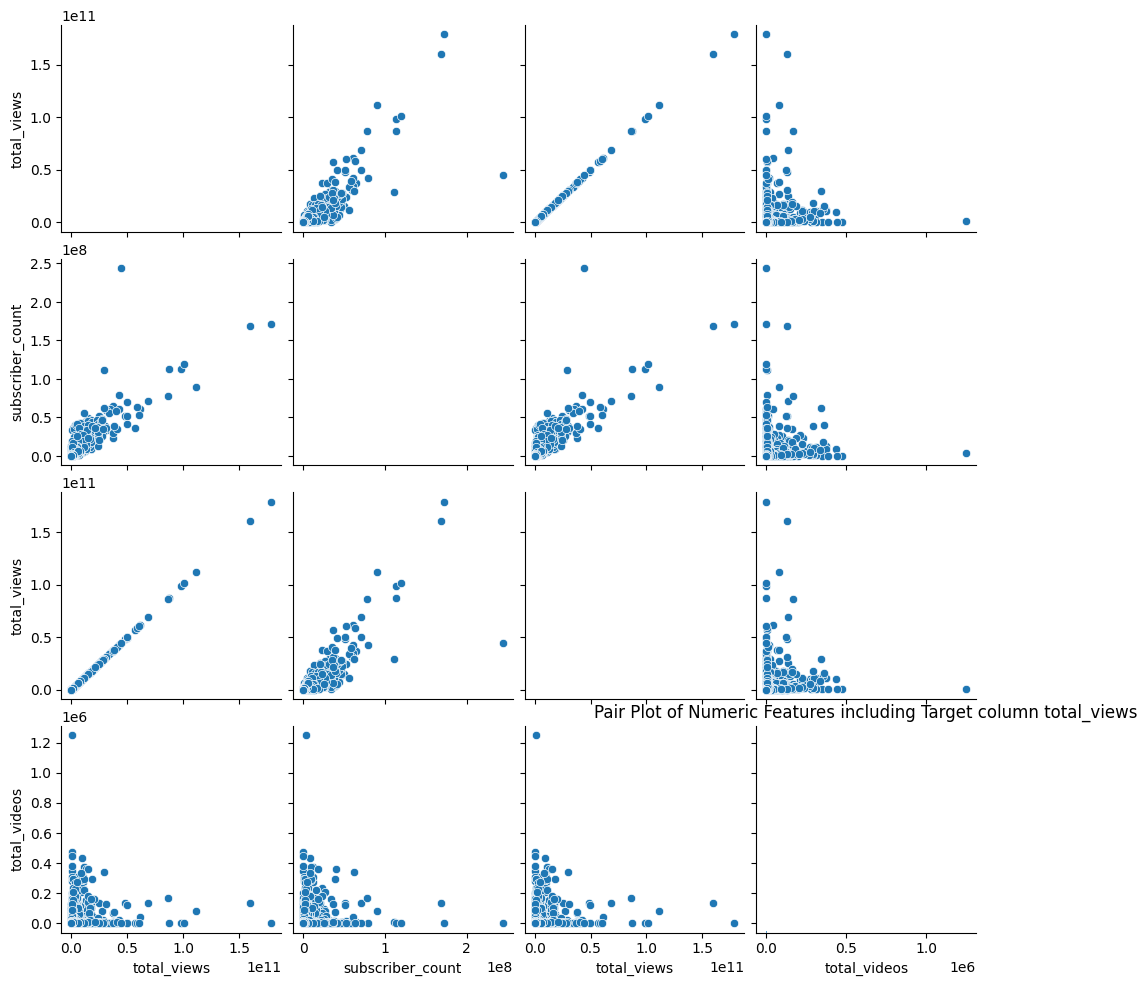

<module 'matplotlib.pyplot' from 'c:\\Users\\Jorge\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [15]:

dafu.eda4_num(df,target,df.select_dtypes(include=['float64', 'int64']).columns)

**Step 6: Data transformation with EDA**

Reading keywords (only the ones using English alphabet) from DataFrame prepared in advance, go to last step of this notebook to see how  I get this DataFrame

Filtering rows by existing keywords in keywords dataframe

In [16]:
file_path = './data/youtube/youtube_channels_1M_clean_keywords.csv'
df_keywords=pd.read_csv(file_path)
df_keywords=df_keywords.sort_values(by="Count",ascending=False)
df_keywords=df_keywords.head(500)
# Preprocess the keywords in df_data: lowercase and replace spaces with underscores
df['keywords'] = df['keywords'].str.lower().str.replace(' ', '_')

# Convert the keywords in df_data to a list of keywords for each row
df['keyword_list'] = df['keywords'].str.split(',')

# Check if any keyword in each row's list is in the df_keywords
df['keyword_match'] = df['keyword_list'].apply(
    lambda keywords: any(keyword in df_keywords['Keyword'].values for keyword in keywords)
)

# Filter df_data based on whether there's a keyword match
filtered_df = df[df['keyword_match']]

# Drop the temporary columns if they are no longer needed
#filtered_df = filtered_df.drop(['keyword_list', 'keyword_match'], axis=1)
filtered_df = filtered_df.drop(['keyword_match'], axis=1)
filtered_df
df=filtered_df




Filtering by total_videos greater than 0 and adding a date column with datetime type

Also adding year,month,day and dayofweek as numeric

In [17]:
#Filter total_videos greater than 0
df= df[df['total_videos']>=0]
#Add a column datetime type and extract numeric year,month, date and date of the week
df['join_date_datetime']=pd.to_datetime(df['join_date'])
df['year'] = df['join_date_datetime'].dt.year
df['month'] = df['join_date_datetime'].dt.month
df['day'] = df['join_date_datetime'].dt.day
df['dayofweek'] = df['join_date_datetime'].dt.dayofweek
#filtering columns for later ML/DL


Preparing list of columns for dropping on PCA

In [18]:
features_cat= ['keywords']
drop_columns=['channel_id', 
              'channel_link', 
              'channel_name', 
              'banner_link', 
              'description', 
              'keywords', 
              'avatar', 
              'country',
              'keyword_list',
              'country_formatted',
              'join_date',
              'join_date_datetime']

OneHotEncoder with country and keywords due to issues with working on lists

Adding a column with country name formatted 

In [19]:
#OneHotEncoder due to issues with working on lists
df['country_formatted']=df['country'].str.lower().str.replace(' ', '_').str.replace('&','and')

new_cols_df = pd.DataFrame(0, index=df.index, columns= df_keywords['Keyword'].tolist() + list(set(df['country_formatted'].unique())))
# Concatenate the new DataFrame with the existing DataFrame
df = pd.concat([df, new_cols_df], axis=1)

for index, row in df.iterrows():
    # Preprocess and split the keywords
    keywords = row['keywords'].lower().replace(' ', '_').split(',')
    # Update the corresponding columns
    for keyword in keywords:
        if keyword in df.columns:
            df.at[index, keyword] = 1
    country = row['country_formatted']
    # Update the corresponding columns
    if country in df.columns:
        df.at[index, country] = 1


In [20]:
df.dropna(inplace=True)


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110084 entries, 3 to 1095225
Columns: 683 entries, channel_id to mauritius
dtypes: datetime64[ns](1), float64(10), int64(661), object(11)
memory usage: 574.5+ MB


Testing removing outliers for improving the model

In [18]:
columns=['subscriber_count','total_videos']
#uncomment this for removing outliers 
df=dafu.remove_outliers(df,columns,[5,95])


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115896 entries, 3 to 1095226
Columns: 683 entries, channel_id to russia
dtypes: datetime64[ns](1), float64(10), int64(661), object(11)
memory usage: 608.8+ MB


In [20]:
df.describe()

subscriber_count   total_views  total_videos  \
count      1.158960e+05  1.158960e+05  1.158960e+05   
mean       2.308909e+05  8.833637e+07  1.138073e+03   
min        1.000000e+00  1.000000e+00  1.000000e+00   
25%        1.010000e+03  1.433678e+05  1.450000e+02   
50%        4.850000e+03  8.391330e+05  3.450000e+02   
75%        4.250000e+04  8.168781e+06  7.970000e+02   
max        1.720000e+08  1.788442e+11  1.248360e+06   
std        1.728542e+06  1.196010e+09  7.598676e+03   

       mean_views_last_30_videos  median_views_last_30_videos  \
count               1.158960e+05                 1.158960e+05   
mean                3.873793e+04                 2.231049e+04   
min                 0.000000e+00                 0.000000e+00   
25%                 1.679125e+02                 7.450000e+01   
50%                 8.435000e+02                 3.205000e+02   
75%                 5.790317e+03                 2.353125e+03   
max                 1.298768e+08                 1.005993e+08   
std                 5.475180e+05                 4.023646e+05   

       std_views_last_30_videos  videos_per_week  \
count              1.158960e+05    115896.000000   
mean               5.232690e+04         2.029626   
min                0.000000e+00         0.250000   
25%                1.947738e+02         0.500000   
50%                1.073504e+03         1.000000   
75%                8.068115e+03         2.750000   
max                1.327944e+08         7.500000   
std                7.143348e+05         2.180819   

                  join_date_datetime           year          month  ...  \
count                         115895  115895.000000  115895.000000  ...   
mean   2016-12-30 13:17:18.888649216    2016.505052       6.446162  ...   
min              2005-06-22 00:00:00    2005.000000       1.000000  ...   
25%              2013-05-28 00:00:00    2013.000000       3.000000  ...   
50%              2017-09-05 00:00:00    2017.000000       6.000000  ...   
75%              2020-12-05 00:00:00    2020.000000      10.000000  ...   
max              2024-03-09 00:00:00    2024.000000      12.000000  ...   
std                              NaN       4.784149       3.492458  ...   

       united_kingdom         jordan       bulgaria        morocco  \
count   115896.000000  115896.000000  115896.000000  115896.000000   
mean         0.076482       0.000337       0.000984       0.000958   
min          0.000000       0.000000       0.000000       0.000000   
25%          0.000000       0.000000       0.000000       0.000000   
50%          0.000000       0.000000       0.000000       0.000000   
75%          0.000000       0.000000       0.000000       0.000000   
max          1.000000       1.000000       1.000000       1.000000   
std          0.265769       0.018341       0.031348       0.030933   

       st_vincent_and_the_grenadines      sri_lanka  us_outlying_islands  \
count                  115896.000000  115896.000000        115896.000000   
mean                        0.000009       0.002968             0.000009   
min                         0.000000       0.000000             0.000000   
25%                         0.000000       0.000000             0.000000   
50%                         0.000000       0.000000             0.000000   
75%                         0.000000       0.000000             0.000000   
max                         1.000000       1.000000             1.000000   
std                         0.002937       0.054400             0.002937   

              poland       colombia         russia  
count  115896.000000  115896.000000  115896.000000  
mean        0.003943       0.001700       0.003753  
min         0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000  
75%         0.000000       0.000000       0.000000  
max         1.000000       1.000000       1.000000  
std         0.062671       0.041194     

Applying only scaler

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110084 entries, 3 to 1095225
Columns: 683 entries, channel_id to russia
dtypes: datetime64[ns](1), float64(10), int64(661), object(11)
memory usage: 574.5+ MB


**Step 7: ML/DL models used**

Models used for testing


- RandomForestRegressor

- LinearRegression

- DecisionTreeRegressor

- GradientBoostingRegressor

- KNeighborsRegressor

- XGBRegressor

- LGBMRegressor

- CatBoostRegressor

- SVR

- Elastic

- Ridge

- Lasso

- MLPRegressor

- Keras with Tensorflow

In [28]:
target=['total_views']

# Assuming df is your DataFrame with more than 100 features
# 1. Standardizing the data
df_features = df.drop(target+drop_columns,axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_features,#X
                                                    df[target].squeeze(),#Y
                                                    test_size=0.2,
                                                    random_state=42)

X_train_scaled,X_test_scaled=dafu.scaler_of_x_train_and_x_test(X_train,X_test)

rfr_model = RandomForestRegressor(random_state=42)
lr_model = LinearRegression()
dtr_model = DecisionTreeRegressor(random_state=42)
gbr_model = GradientBoostingRegressor(random_state=42)
knr_model=KNeighborsRegressor()
xgb_model=XGBRegressor(random_state=42)
lgb_model=LGBMRegressor(random_state=42,verbose=-100)
cbr_model=CatBoostRegressor(random_state=42,verbose=False)
svr_model = SVR()
elastic_model = ElasticNet()
ridge_model = Ridge()
lasso_model = Lasso()
mlp_model = MLPRegressor()
tfk_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.12),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.04)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.02)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(1)  # Output layer for regression
])

# Compile the model

tfk_model.compile(optimizer='adam', loss='mean_squared_error')


# Train the model

models={'RandomForestRegressor':rfr_model,
        'LinearRegression':lr_model,
        'DecisionTreeRegressor':dtr_model,
        'GradientBoostingRegressor':gbr_model,
        'KNeighborsRegressor':knr_model,
        'XGBRegressor':xgb_model,
        'LGBMRegressor':lgb_model,
        'CatBoostRegressor':cbr_model,
        'Ridge':ridge_model,
        'Lasso':lasso_model,
        'MLP':mlp_model,
        'ElasticNet' : elastic_model,
        'Keras':tfk_model
        }




Metrics of each ML model are saved for later comparison

In [32]:
list_df_metrics=[]
for key,model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
# Metrics
    print(f"{key} R^2 score:", round(r2_score(y_test, preds), 4))
    print(f"{key} MAE score:", round(mean_absolute_error(y_test, preds), 4))
    print(f"{key} MSE score:", round(mean_squared_error(y_test, preds), 4))
    print(f"{key} RMSE score:", round(np.sqrt(mean_squared_error(y_test, preds)), 4))
    print(f"{key} MAPE score:", round(tb.mean_absolute_percentage_error(y_test, preds), 4))
    list_df_metrics.append(tb.arima_metrics(y_test,key,"","",preds))
    #if key in ['LinearRegression','Ridge', 'Lasso', 'ElasticNet','KNeighborsRegressor']:
    #    importances=model.coef_
    #else:
    #    importances =model.feature_importances_
    #feature_importances = pd.DataFrame(importances, index=df_features.columns.to_list(), columns=["importance"]).sort_values("importance", ascending=False)
    #print(f"{key}",importances)
df_metrics=pd.concat(list_df_metrics, ignore_index=True)

RandomForestRegressor R^2 score: 0.7594
RandomForestRegressor MAE score: 46064670.5093
RandomForestRegressor MSE score: 6.055201635650257e+17
RandomForestRegressor RMSE score: 778151761.2683
RandomForestRegressor MAPE score: 294.1979
LinearRegression R^2 score: -8.867316082178203e+16
LinearRegression MAE score: 3832505240997390.0
LinearRegression MSE score: 2.2316643777165503e+35
LinearRegression RMSE score: 4.72404951044816e+17
LinearRegression MAPE score: 75901627049905.39
DecisionTreeRegressor R^2 score: 0.8573
DecisionTreeRegressor MAE score: 57339956.0751
DecisionTreeRegressor MSE score: 3.5922956852731514e+17
DecisionTreeRegressor RMSE score: 599357629.9066
DecisionTreeRegressor MAPE score: 208.4632
GradientBoostingRegressor R^2 score: 0.854
GradientBoostingRegressor MAE score: 46688688.1902
GradientBoostingRegressor MSE score: 3.674282296817842e+17
GradientBoostingRegressor RMSE score: 606158584.5979
GradientBoostingRegressor MAPE score: 57148.6
KNeighborsRegressor R^2 score: 0.

c:\Users\Jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.175e+22, tolerance: 1.102e+19
  model = cd_fast.enet_coordinate_descent(


Lasso R^2 score: 0.7674
Lasso MAE score: 109087830.1809
Lasso MSE score: 5.854042439528627e+17
Lasso RMSE score: 765117143.9413
Lasso MAPE score: 1153789.6729


c:\Users\Jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP R^2 score: -0.0037
MLP MAE score: 97709176.0982
MLP MSE score: 2.5260298326061036e+18
MLP RMSE score: 1589348870.6405
MLP MAPE score: 29193.7664
ElasticNet R^2 score: 0.0019
ElasticNet MAE score: 159004624.1895
ElasticNet MSE score: 2.5118962986014515e+18
ElasticNet RMSE score: 1584896305.3151
ElasticNet MAPE score: 1699589.7105

689/689 [==============================] - 3s 5ms/step
Keras R^2 score: -0.0006
Keras MAE score: 97080107.3427
Keras MSE score: 2.518156766497489e+18
Keras RMSE score: 1586870116.4549
Keras MAPE score: 80310.4397


Saving results from metrics DataFrame

In [33]:
df_metrics.to_csv(f'./data/youtube/{tb.datetime_naming_convention()}_metrics.csv')

Applying log and sqrt to target

In [72]:
def function_models_log_sqrt(df:pd.DataFrame,target:list,drop_columns:list,bool_log:True,bool_sqrt:False):

    if (bool_log and bool_sqrt) or (bool_log==False and bool_sqrt==False):
        raise ValueError("bool_log and bool_sqrt cannot be True/False at the same time")
        return None
    df_features = df.drop(target+drop_columns,axis=1)
    X_train, X_test, y_train, y_test = train_test_split(df_features,#X
                                                        df[target].squeeze(),#Y
                                                        test_size=0.2,
                                                        random_state=42)

    X_train_scaled,X_test_scaled=dafu.scaler_of_x_train_and_x_test(X_train,X_test)
    rfr_model = RandomForestRegressor(random_state=42)
    lr_model = LinearRegression()
    dtr_model = DecisionTreeRegressor(random_state=42)
    gbr_model = GradientBoostingRegressor(random_state=42)
    knr_model=KNeighborsRegressor()
    xgb_model=XGBRegressor(random_state=42)
    lgb_model=LGBMRegressor(random_state=42,verbose=-100)
    cbr_model=CatBoostRegressor(random_state=42,verbose=False)
    #svr_model = SVR()
    elastic_model = ElasticNet()
    ridge_model = Ridge()
    lasso_model = Lasso()
    mlp_model = MLPRegressor()
    tfk_model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.12),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.04)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.6),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.02)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)  # Output layer for regression
    ])

    # Compile the model

    tfk_model.compile(optimizer='adam', loss='mean_squared_error')


    # Train the model
    models={}
    models={'RandomForestRegressor':rfr_model,
                'LinearRegression':lr_model,
                'DecisionTreeRegressor':dtr_model,
                'GradientBoostingRegressor':gbr_model,
                'KNeighborsRegressor':knr_model,
                'XGBRegressor':xgb_model,
                'LGBMRegressor':lgb_model,
                'CatBoostRegressor':cbr_model,
                'Ridge':ridge_model,
                'Lasso':lasso_model,
                'MLP':mlp_model,
                'ElasticNet' : elastic_model,
                'Keras':tfk_model
                }
    list_df_metrics=[]
    for key,model in models.items():
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
        #if bool_log:
        #    original_scale_predictions = np.exp(preds)
        #    original_y_test=np.exp(y_test)
        #if bool_sqrt:
        #    original_scale_predictions = np.square(preds)
        #    original_y_test=np.square(y_test)
    # Metrics
        metrics_dict={}
        value_r2_score=r2_score(y_test, preds)
        value_mae_score=mean_absolute_error(y_test, preds)
        value_mse_score=mean_squared_error(y_test, preds)
        value_rmse_score=np.sqrt(mean_squared_error(y_test, preds))
        value_mape_score=tb.mean_absolute_percentage_error(y_test, preds)
        metrics_dict['r2_score']=value_r2_score
        metrics_dict['mae_score']=value_mae_score
        metrics_dict['mse_score']=value_mse_score
        metrics_dict['rmse_score']=value_rmse_score
        metrics_dict['mape_score']=value_mape_score
        print(f"{key} R^2 score:", round(value_r2_score, 4))
        print(f"{key} MAE score:", round(value_mae_score, 4))
        print(f"{key} MSE score:", round(value_mse_score, 4))
        print(f"{key} RMSE score:", round(value_rmse_score, 4))
        print(f"{key} MAPE score:", round(value_mape_score, 4))
        if bool_log:
            list_df_metrics.append(tb.model_metrics(metrics_dict,key,"transformation","log",preds))
            log_or_sqrt="log"
            #list_df_metrics.append(tb.arima_metrics(original_y_test,key,"transformation","exp",original_scale_predictions))
        if bool_sqrt:
            list_df_metrics.append(tb.model_metrics(y_test,key,"transformation","sqrt",preds))
            #filename = f'./data/youtube/{tb.datetime_naming_convention()}_{key}_sqrt'
            log_or_sqrt="sqrt"
        filename = f'./data/youtube/{tb.datetime_naming_convention()}_{key}_{log_or_sqrt}'
        ###

        # Create a scatter plot
        tb.plot_test_vs_preds(y_test,preds,key,log_or_sqrt)

        ###
            #list_df_metrics.append(tb.arima_metrics(original_y_test,key,"transformation","square",original_scale_predictions))
        #if key in ['LinearRegression','Ridge', 'Lasso', 'ElasticNet','KNeighborsRegressor']:
        #    importances=model.coef_
        #else:
        #    importances =model.feature_importances_
        #feature_importances = pd.DataFrame(importances, index=df_features.columns.to_list(), columns=["importance"]).sort_values("importance", ascending=False)        #print(f"{key}",importances)

        if key != 'Keras':  # Keras models uses another format
            filename = f'{filename}.pkl'
            with open(filename, 'wb') as file:
                pickle.dump(model, file)
        else:
            filename = f'{filename}.h5'
            model.save(filename)  # Saves the Keras model
        print(f"filename:{filename}")
    df_metrics=pd.concat(list_df_metrics, ignore_index=True)
    df_metrics.to_csv(f'./data/youtube/{tb.datetime_naming_convention()}_metrics.csv')
    dict_data_function={}
    
    try:
        dict_data_function={
        'models':models,
        'X_train':X_train, 
        'X_test':X_test, 
        'y_train':y_train, 
        'y_test':y_test,
        'X_train_scaled':X_train_scaled,
        'X_test_scaled':X_test_scaled,
    }
    except ImportError:
        dict_data_function={
        'models':0,
        'X_train':0, 
        'X_test':0, 
        'y_train':0, 
        'y_test':0,
        'X_train_scaled':0,
        'X_test_scaled':0
        }
    print("Success")
    return dict_data_function
    

Applying Log and Sqrt to target on two additional columns 

In [ ]:
original_target=target
df["total_viewslog"]=np.log(df[target])
df["total_viewssqrt"]=np.sqrt(df[target])
drop_columns_log=drop_columns + ["total_viewssqrt"]  + [original_target]
drop_columns_sqrt=drop_columns+ ["total_viewslog"]  + [original_target]



Excerpt from 

https://www.kaggle.com/discussions/product-feedback/164183

**There are four assumptions associated with a linear regression model:**

1-Linearity: The relationship between X and the mean of Y is linear.

2-Homoscedasticity: The variance of residual is the same for any value of X.

3-Independence: Observations are independent of each other.

4-Normality: For any fixed value of X, Y is normally distributed

**Skewness** is a measure of the symmetry in a distribution. A symmetrical data set will have a skewness equal to 0. So, a normal distribution will have a skewness of 0. Skewness essentially measures the relative size of the two tails.

so that been said ,the objective of choosing features with **skewed_feats>0.75** is because we are searching to work with features that have a more normal-like distribution so this why we apply a log transformation so to normalize the distribution ( skewness =0) cause models cause linear models work better on or normalized data. well to be more specific it's a good practice to always normalize your features.

**Transformations**

In data analysis transformation is the replacement of a variable by a function of that variable. Example replacing a variable x by the square root of x or the logarithm of x.

**Reasons for using transformations**

**Convenience**: A transformed scale may be as natural as the original scale and more convenient for a specific purpose (e.g. percentages rather than original data, sines rather than degrees). One important example is standardization.

**Reducing skewness**: A transformation may be used to reduce skewness. A distribution that is symmetric or nearly so is often easier to handle and interpret than a skewed distribution. To reduce right skewness, take roots or logarithms or reciprocals (roots are weakest). This is the commonest problem in practice. To reduce left skewness, take squares or cubes or higher powers.

**Equal spreads**: A transformation may be used to produce approximately equal spreads, despite marked variations in level, which again makes data easier to handle and interpret.

**Linear relationships**: When looking at relationships between variables, it is often far easier to think about patterns that are approximately linear than about patterns that are highly curved.
**Additive relationships**: Relationships are often easier to analyse when additive rather than multiplicative.

**Logarithm**

The logarithm, x to log base 10 of x, or x to log base e of x (ln x), or x to log base 2 of x, is a strong transformation with a major effect on distribution shape. It is commonly used for reducing right skewness and is often appropriate for measured variables. It can not be applied to zero or negative values. One unit on a logarithmic scale means a multiplication by the base of logarithms being used.

RandomForestRegressor R^2 score: 0.9337
RandomForestRegressor MAE score: 0.5819
RandomForestRegressor MSE score: 0.6162
RandomForestRegressor RMSE score: 0.785
RandomForestRegressor MAPE score: 4.5476


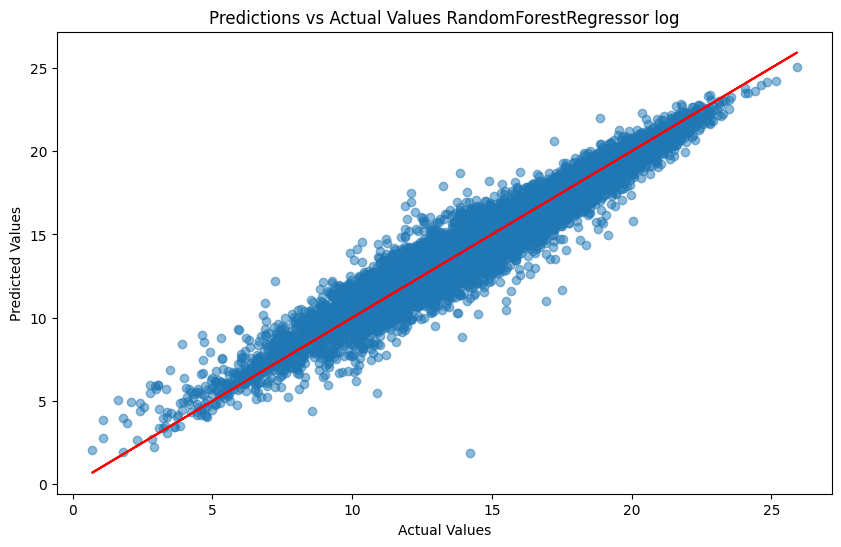

filename:./data/youtube/20240406_234130_RandomForestRegressor_log.pkl
LinearRegression R^2 score: -7.740921740669247e+21
LinearRegression MAE score: 3518491254.4596
LinearRegression MSE score: 7.193671650326789e+22
LinearRegression RMSE score: 268210209543.313
LinearRegression MAPE score: 30853379052.6044


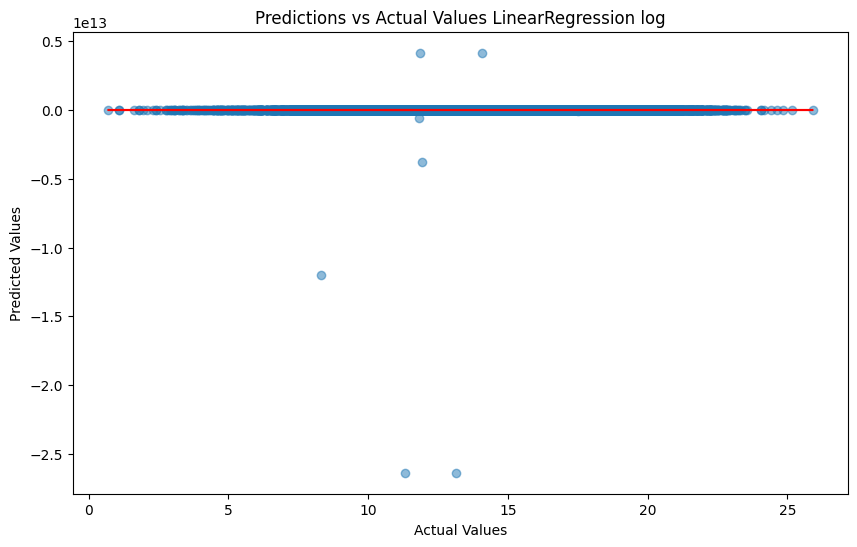

filename:./data/youtube/20240406_234133_LinearRegression_log.pkl
DecisionTreeRegressor R^2 score: 0.8695
DecisionTreeRegressor MAE score: 0.8163
DecisionTreeRegressor MSE score: 1.213
DecisionTreeRegressor RMSE score: 1.1014
DecisionTreeRegressor MAPE score: 6.3529


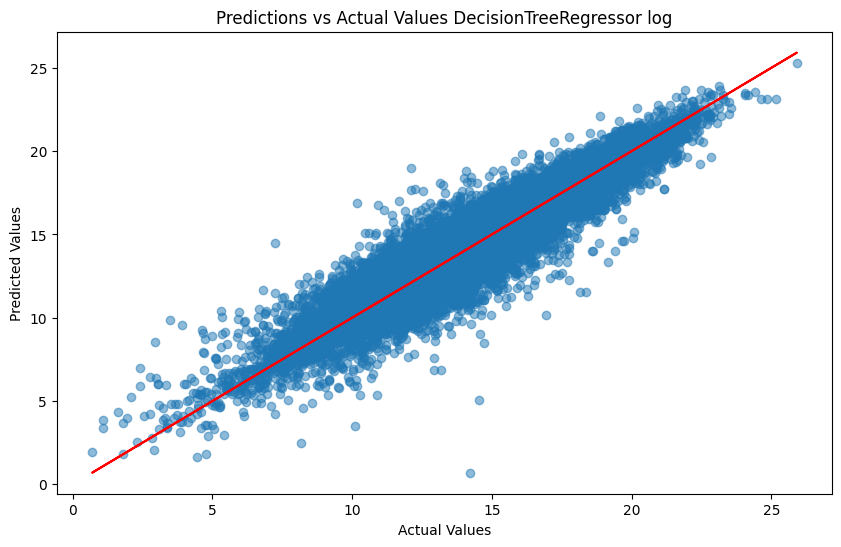

filename:./data/youtube/20240406_234142_DecisionTreeRegressor_log.pkl
GradientBoostingRegressor R^2 score: 0.8892
GradientBoostingRegressor MAE score: 0.7532
GradientBoostingRegressor MSE score: 1.0296
GradientBoostingRegressor RMSE score: 1.0147
GradientBoostingRegressor MAPE score: 6.1693


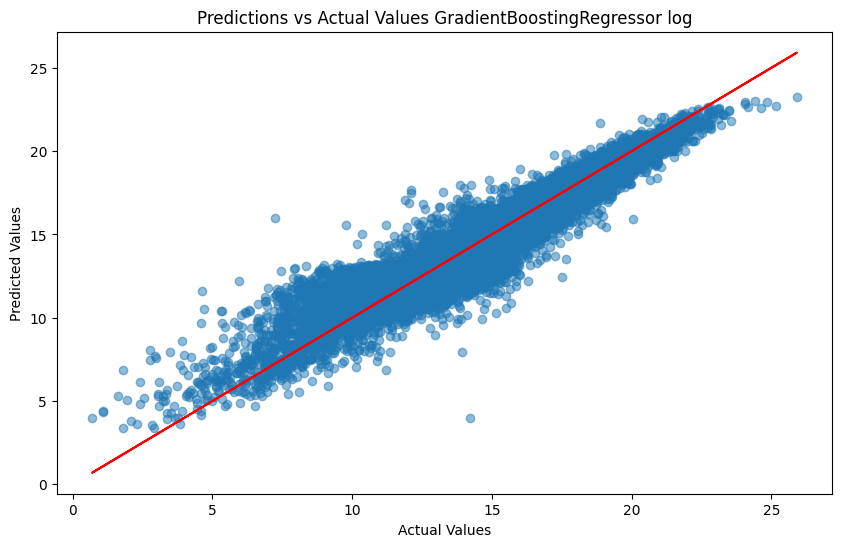

filename:./data/youtube/20240406_234239_GradientBoostingRegressor_log.pkl
KNeighborsRegressor R^2 score: 0.0591
KNeighborsRegressor MAE score: 2.3252
KNeighborsRegressor MSE score: 8.7441
KNeighborsRegressor RMSE score: 2.957
KNeighborsRegressor MAPE score: 18.6684


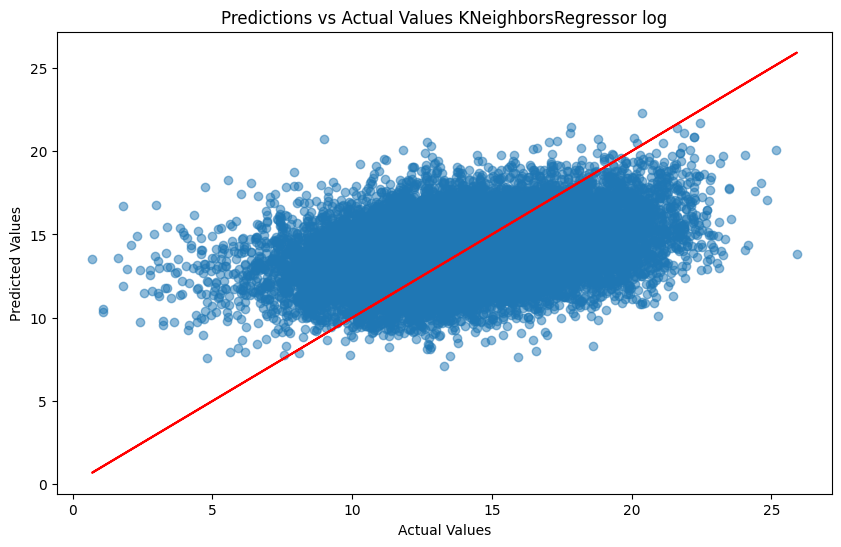

filename:./data/youtube/20240406_234258_KNeighborsRegressor_log.pkl
XGBRegressor R^2 score: 0.9378
XGBRegressor MAE score: 0.5631
XGBRegressor MSE score: 0.5779
XGBRegressor RMSE score: 0.7602
XGBRegressor MAPE score: 4.3952


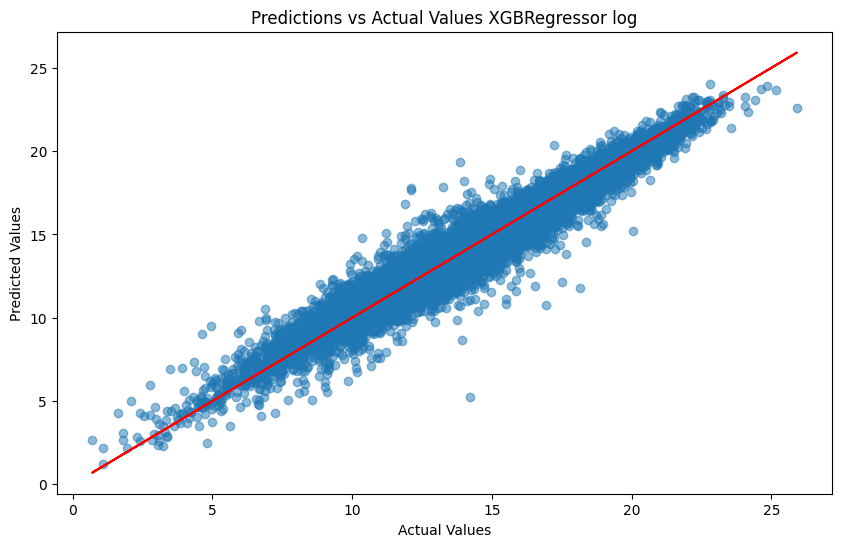

filename:./data/youtube/20240406_234301_XGBRegressor_log.pkl
LGBMRegressor R^2 score: 0.9386
LGBMRegressor MAE score: 0.5606
LGBMRegressor MSE score: 0.5706
LGBMRegressor RMSE score: 0.7554
LGBMRegressor MAPE score: 4.3775


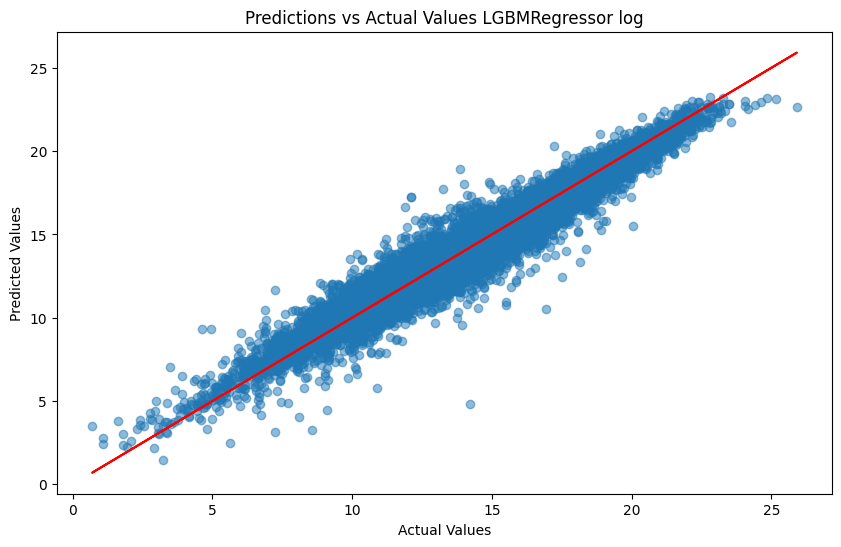

filename:./data/youtube/20240406_234302_LGBMRegressor_log.pkl
CatBoostRegressor R^2 score: 0.9411
CatBoostRegressor MAE score: 0.5458
CatBoostRegressor MSE score: 0.5473
CatBoostRegressor RMSE score: 0.7398
CatBoostRegressor MAPE score: 4.2517


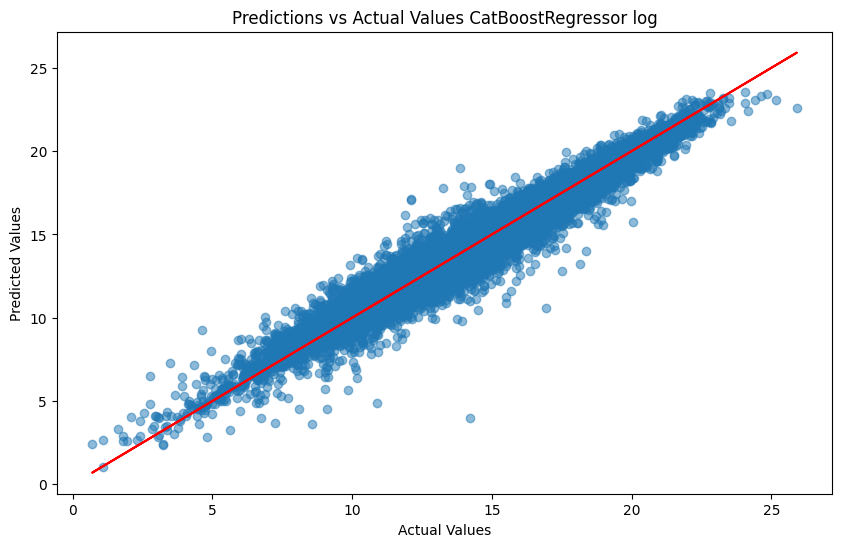

filename:./data/youtube/20240406_234315_CatBoostRegressor_log.pkl
Ridge R^2 score: 0.2548
Ridge MAE score: 2.0275
Ridge MSE score: 6.9248
Ridge RMSE score: 2.6315
Ridge MAPE score: 16.4339


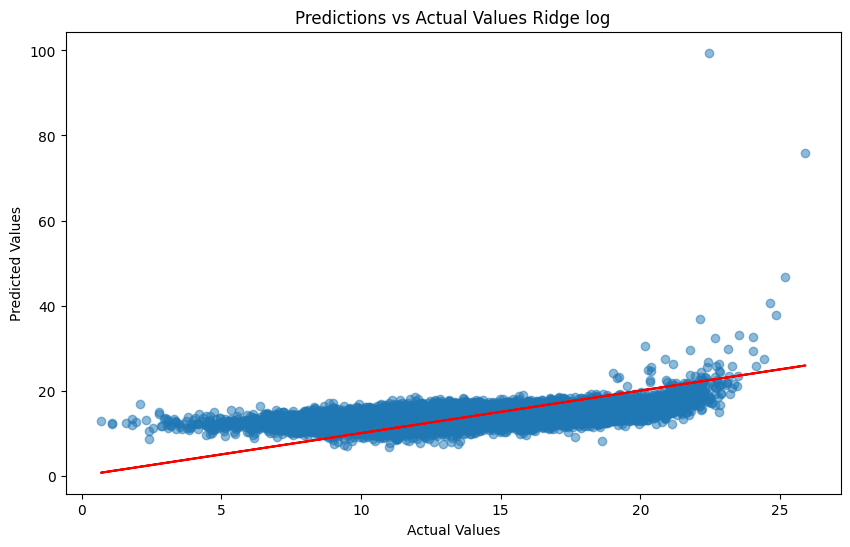

filename:./data/youtube/20240406_234316_Ridge_log.pkl
Lasso R^2 score: -0.0
Lasso MAE score: 2.4107
Lasso MSE score: 9.2934
Lasso RMSE score: 3.0485
Lasso MAPE score: 19.5184


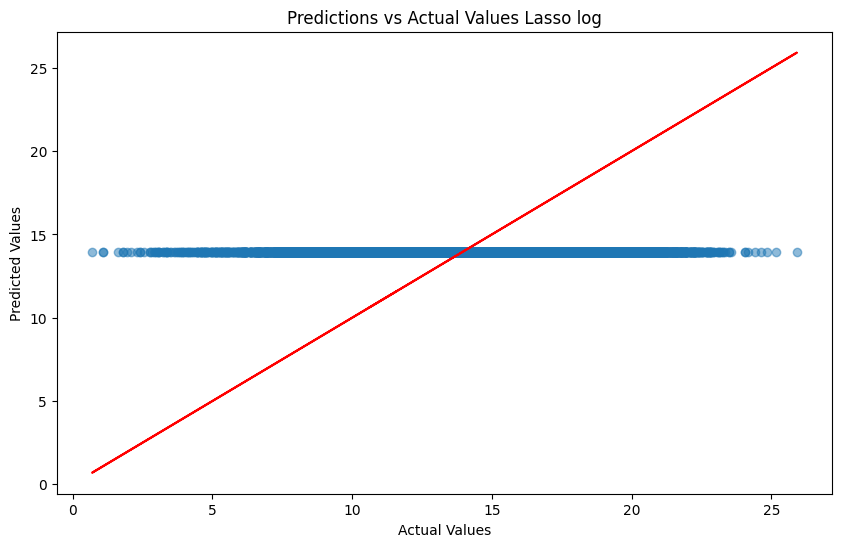

filename:./data/youtube/20240406_234316_Lasso_log.pkl


c:\Users\Jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP R^2 score: 0.671
MLP MAE score: 1.3139
MLP MSE score: 3.057
MLP RMSE score: 1.7484
MLP MAPE score: 11.0591


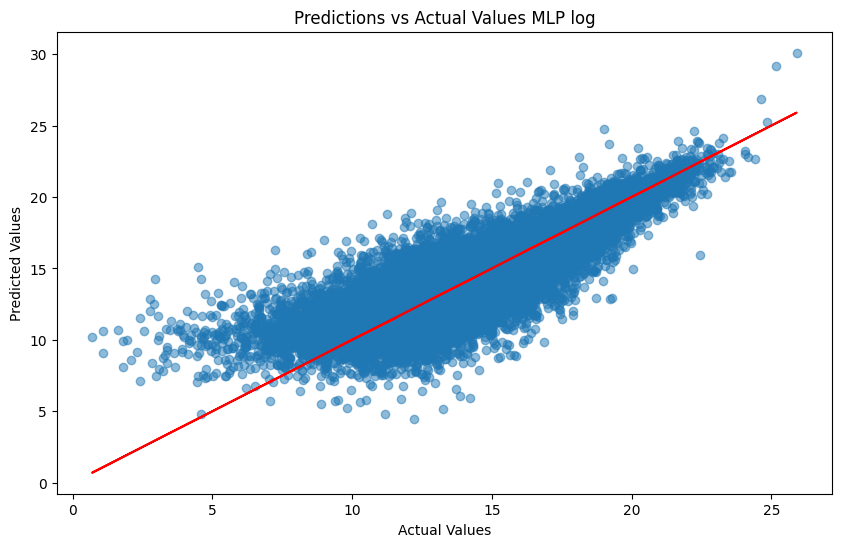

filename:./data/youtube/20240407_000223_MLP_log.pkl
ElasticNet R^2 score: -0.0
ElasticNet MAE score: 2.4107
ElasticNet MSE score: 9.2934
ElasticNet RMSE score: 3.0485
ElasticNet MAPE score: 19.5184


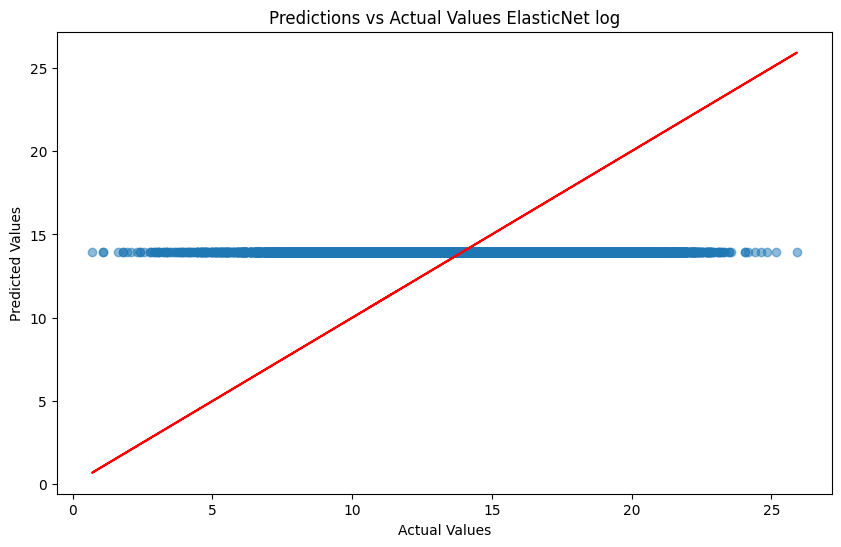

filename:./data/youtube/20240407_000224_ElasticNet_log.pkl
689/689 [==============================] - 1s 1ms/step
Keras R^2 score: -0.388
Keras MAE score: 2.9157
Keras MSE score: 12.8984
Keras RMSE score: 3.5914
Keras MAPE score: 23.3283


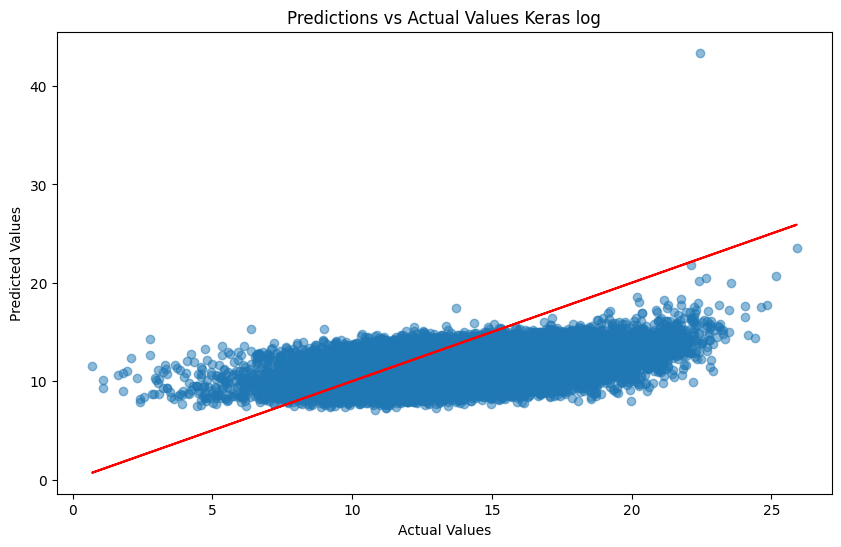

c:\Users\Jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


filename:./data/youtube/20240407_000254_Keras_log.h5
Success
RandomForestRegressor R^2 score: 0.9023
RandomForestRegressor MAE score: 909.2593
RandomForestRegressor MSE score: 8313087.1673
RandomForestRegressor RMSE score: 2883.2425
RandomForestRegressor MAPE score: 35.5129


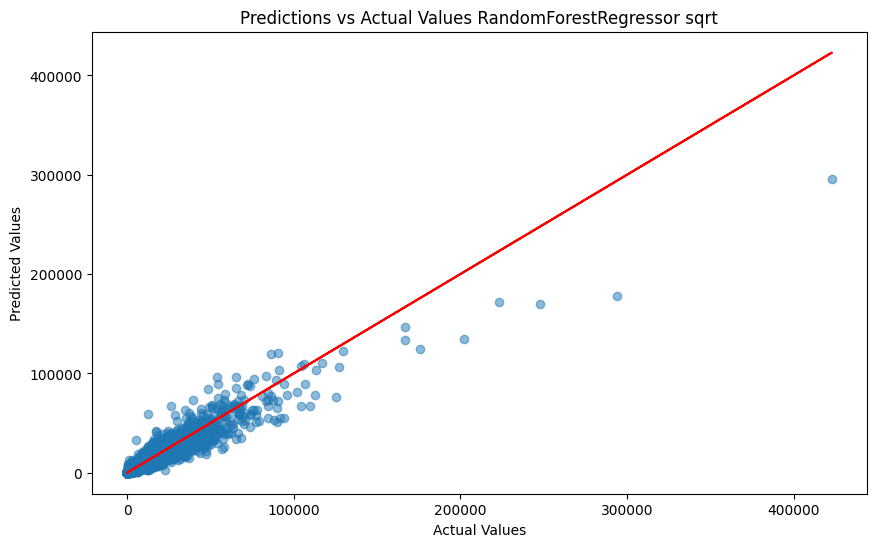

filename:./data/youtube/20240407_001317_RandomForestRegressor_sqrt.pkl
LinearRegression R^2 score: -1.35323740096438e+20
LinearRegression MAE score: 1407913910341.6597
LinearRegression MSE score: 1.1518339039845173e+28
LinearRegression RMSE score: 107323525099789.62
LinearRegression MAPE score: 621338698568.3645


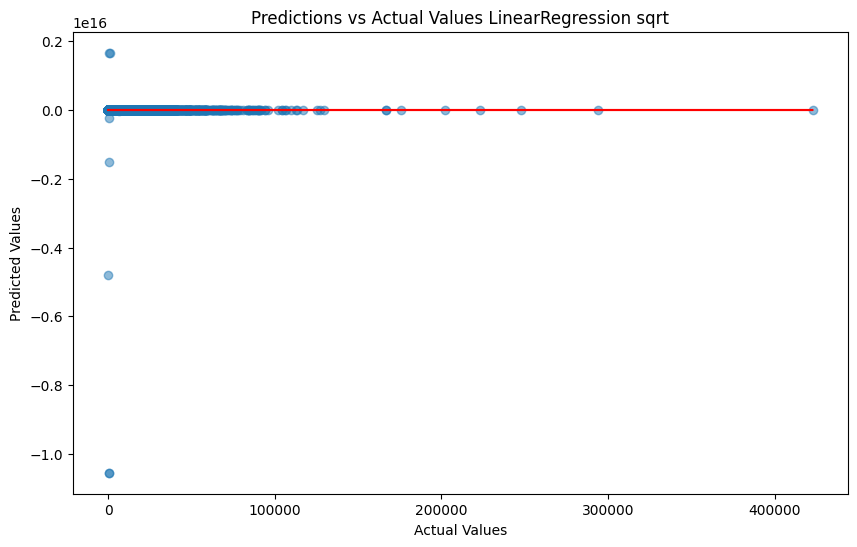

filename:./data/youtube/20240407_001320_LinearRegression_sqrt.pkl
DecisionTreeRegressor R^2 score: 0.8038
DecisionTreeRegressor MAE score: 1263.1954
DecisionTreeRegressor MSE score: 16701590.5906
DecisionTreeRegressor RMSE score: 4086.758
DecisionTreeRegressor MAPE score: 46.2504


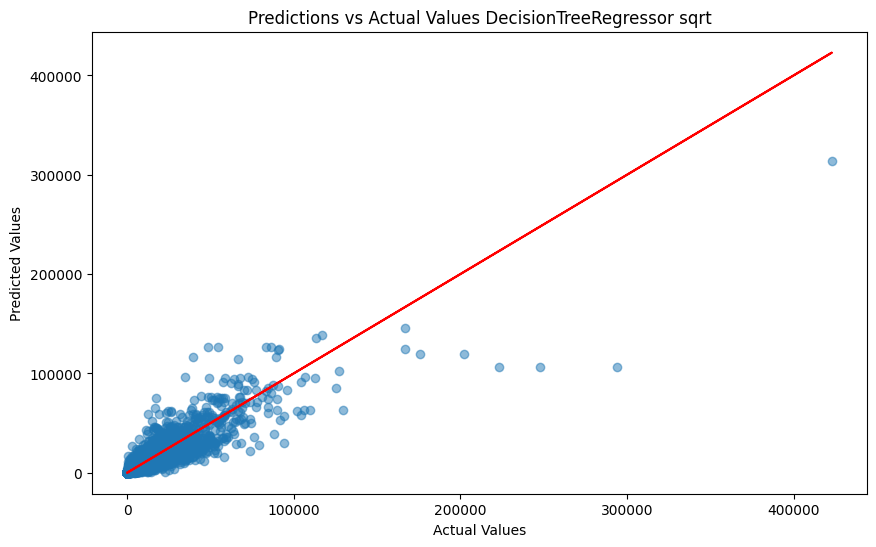

filename:./data/youtube/20240407_001330_DecisionTreeRegressor_sqrt.pkl
GradientBoostingRegressor R^2 score: 0.9147
GradientBoostingRegressor MAE score: 1014.0338
GradientBoostingRegressor MSE score: 7259519.5198
GradientBoostingRegressor RMSE score: 2694.3496
GradientBoostingRegressor MAPE score: 95.183


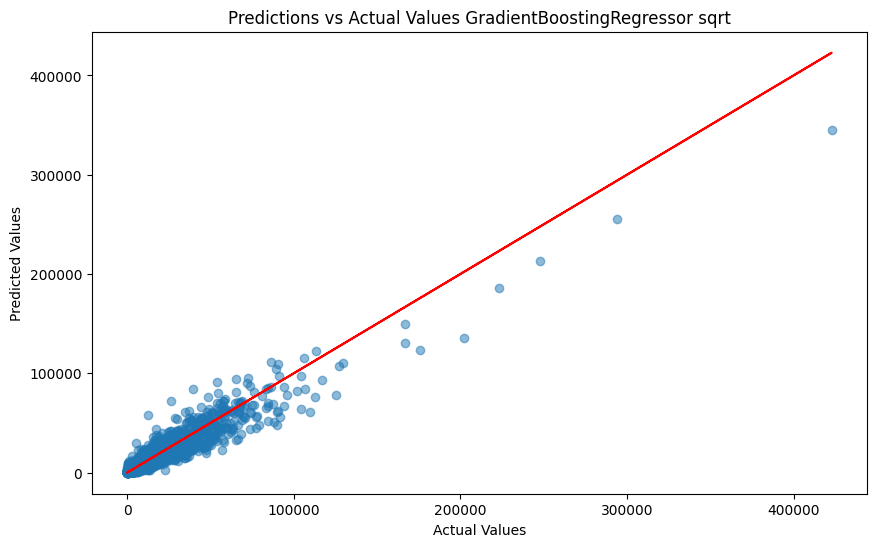

filename:./data/youtube/20240407_001427_GradientBoostingRegressor_sqrt.pkl
KNeighborsRegressor R^2 score: 0.0398
KNeighborsRegressor MAE score: 3827.7414
KNeighborsRegressor MSE score: 81726906.9554
KNeighborsRegressor RMSE score: 9040.2935
KNeighborsRegressor MAPE score: 691.2129


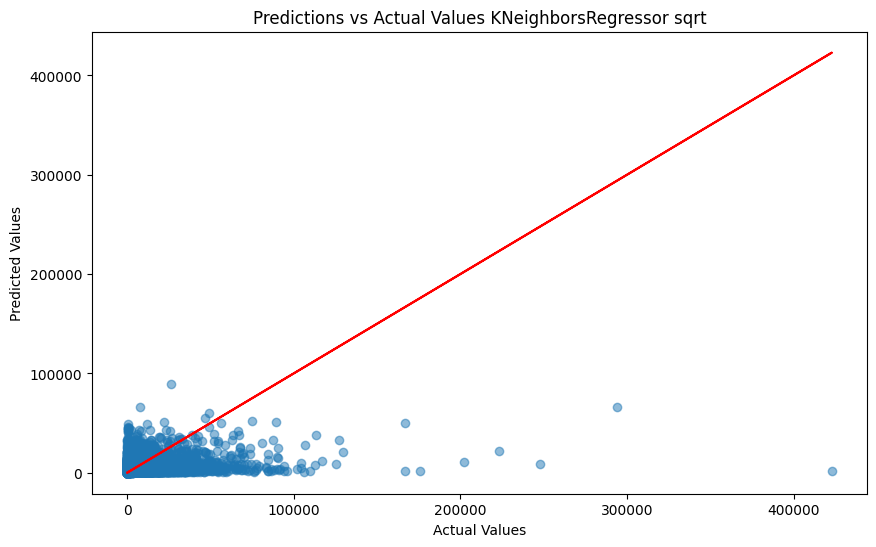

filename:./data/youtube/20240407_001446_KNeighborsRegressor_sqrt.pkl
XGBRegressor R^2 score: 0.8207
XGBRegressor MAE score: 944.3725
XGBRegressor MSE score: 15264010.3688
XGBRegressor RMSE score: 3906.9183
XGBRegressor MAPE score: 51.0799


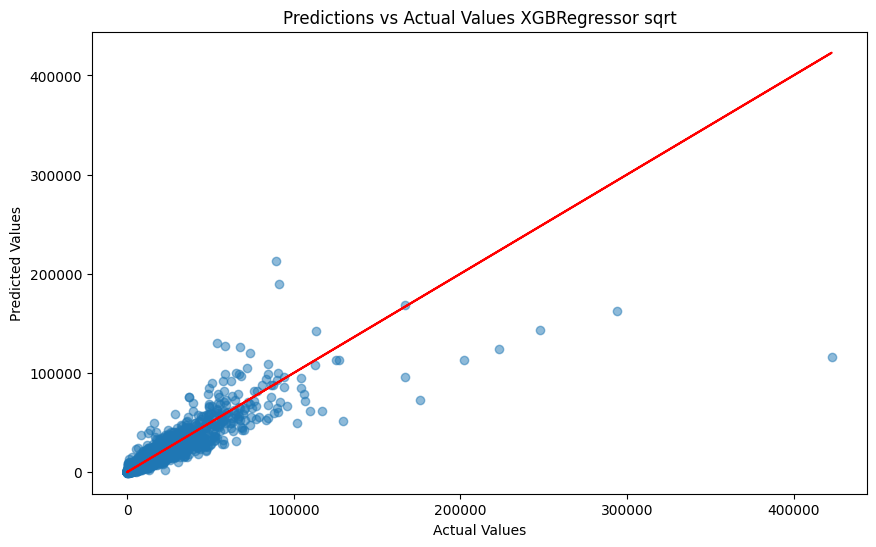

filename:./data/youtube/20240407_001448_XGBRegressor_sqrt.pkl
LGBMRegressor R^2 score: 0.8409
LGBMRegressor MAE score: 941.4708
LGBMRegressor MSE score: 13538095.1998
LGBMRegressor RMSE score: 3679.4151
LGBMRegressor MAPE score: 51.9535


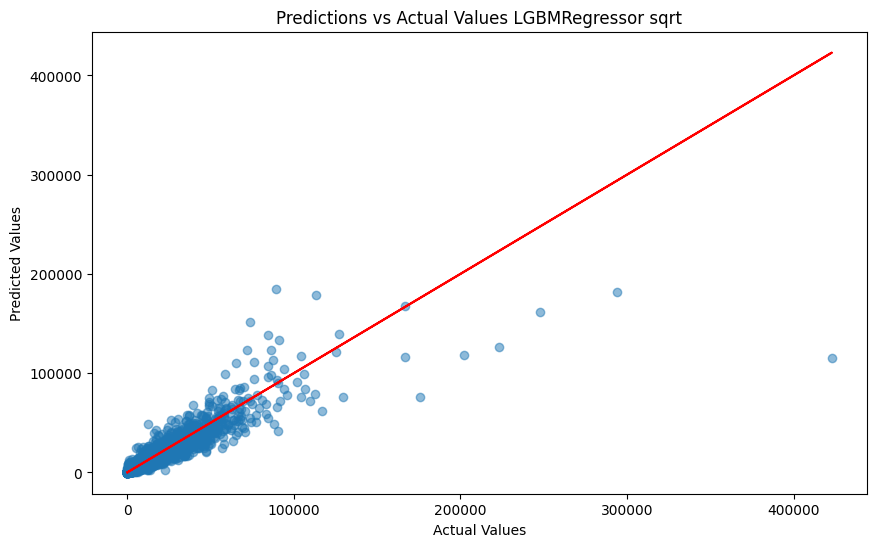

filename:./data/youtube/20240407_001449_LGBMRegressor_sqrt.pkl
CatBoostRegressor R^2 score: 0.8321
CatBoostRegressor MAE score: 930.8357
CatBoostRegressor MSE score: 14288923.2177
CatBoostRegressor RMSE score: 3780.0692
CatBoostRegressor MAPE score: 51.4036


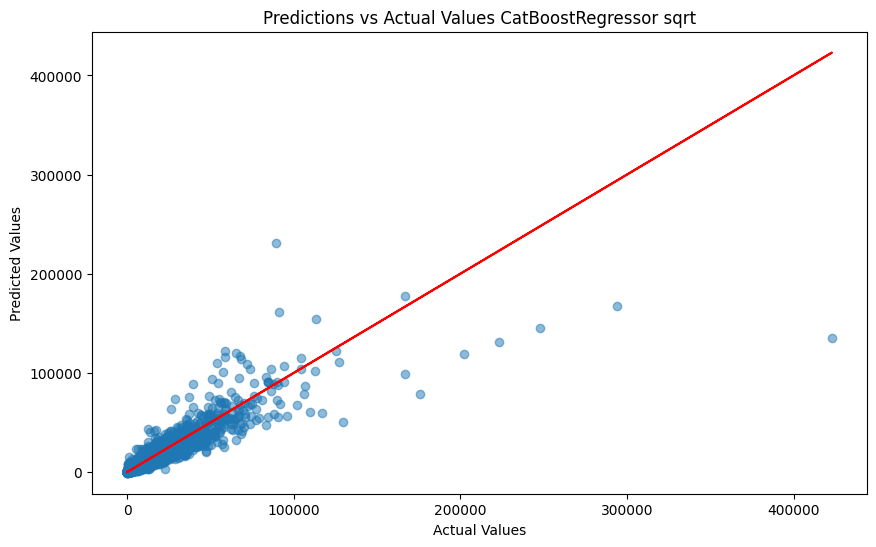

filename:./data/youtube/20240407_001502_CatBoostRegressor_sqrt.pkl
Ridge R^2 score: 0.7113
Ridge MAE score: 2589.9908
Ridge MSE score: 24577161.6593
Ridge RMSE score: 4957.5358
Ridge MAPE score: 528.1473


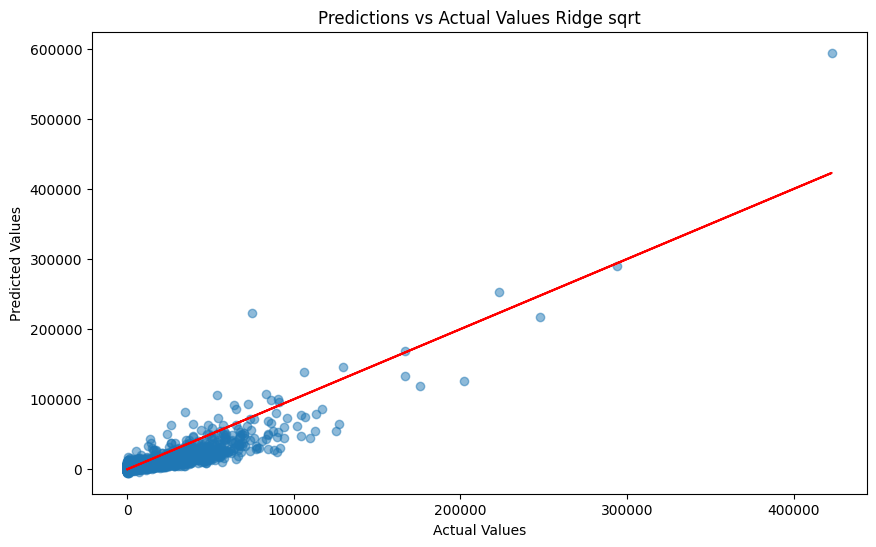

filename:./data/youtube/20240407_001502_Ridge_sqrt.pkl
Lasso R^2 score: 0.7257
Lasso MAE score: 2483.2891
Lasso MSE score: 23351178.4857
Lasso RMSE score: 4832.3057
Lasso MAPE score: 499.4646


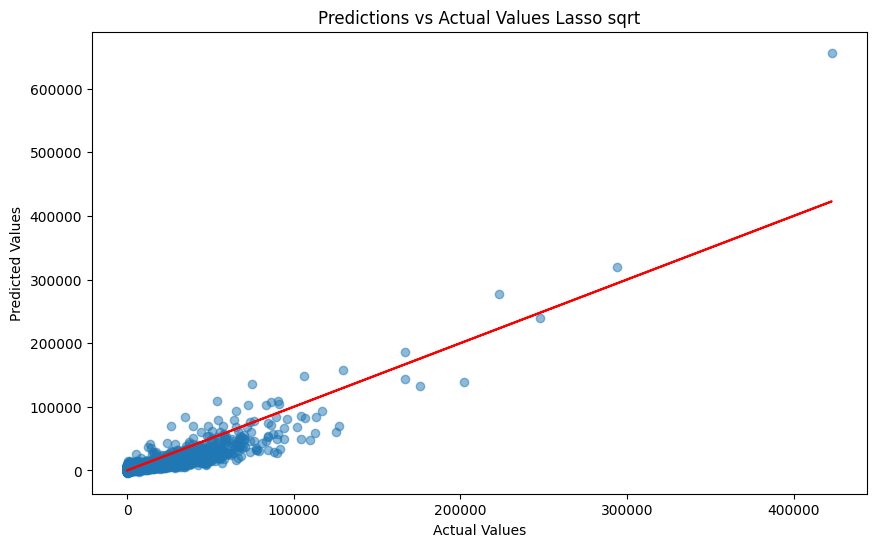

filename:./data/youtube/20240407_001506_Lasso_sqrt.pkl


c:\Users\Jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP R^2 score: 0.3437
MLP MAE score: 3376.4776
MLP MSE score: 55863227.5409
MLP RMSE score: 7474.1707
MLP MAPE score: 661.1993


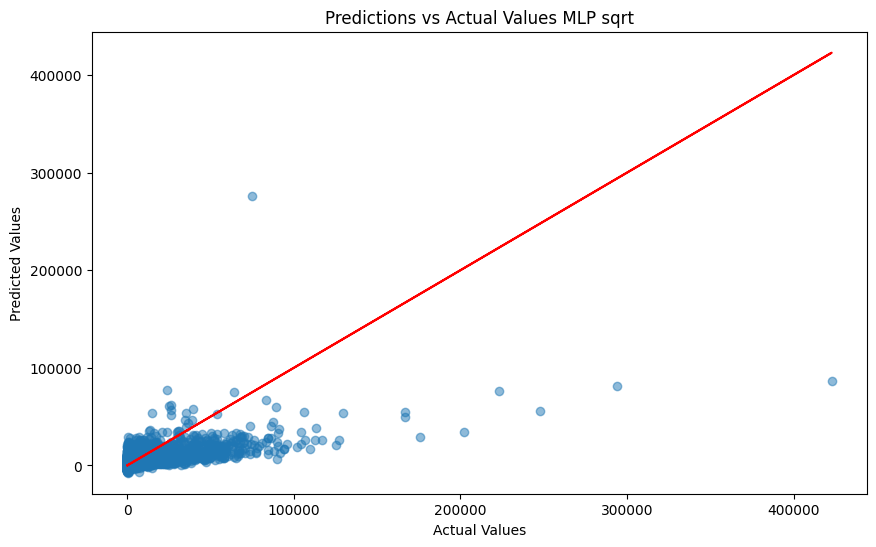

filename:./data/youtube/20240407_003103_MLP_sqrt.pkl
ElasticNet R^2 score: 0.0159
ElasticNet MAE score: 4007.6265
ElasticNet MSE score: 83763249.3539
ElasticNet RMSE score: 9152.2265
ElasticNet MAPE score: 1000.1379


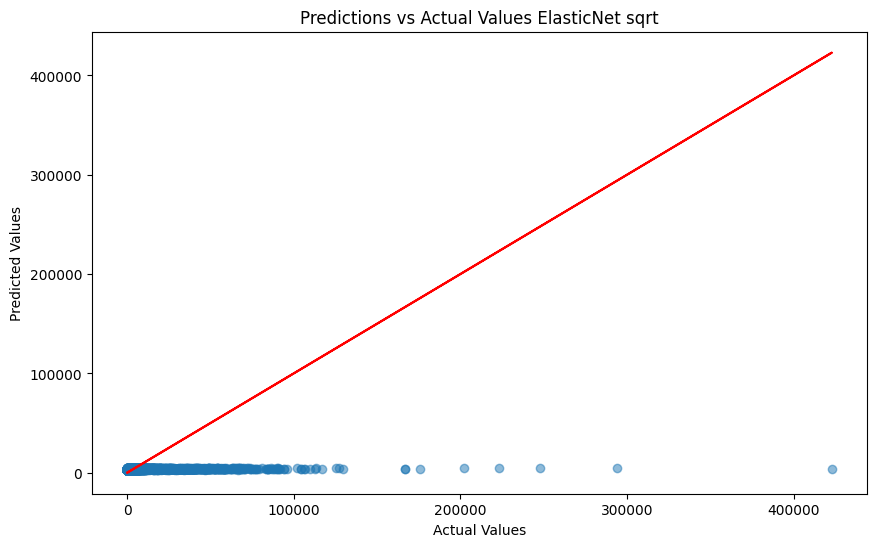

filename:./data/youtube/20240407_003105_ElasticNet_sqrt.pkl
689/689 [==============================] - 1s 1ms/step
Keras R^2 score: -3.7848
Keras MAE score: 3138.7719
Keras MSE score: 407265477.7479
Keras RMSE score: 20180.8196
Keras MAPE score: 1046.5143


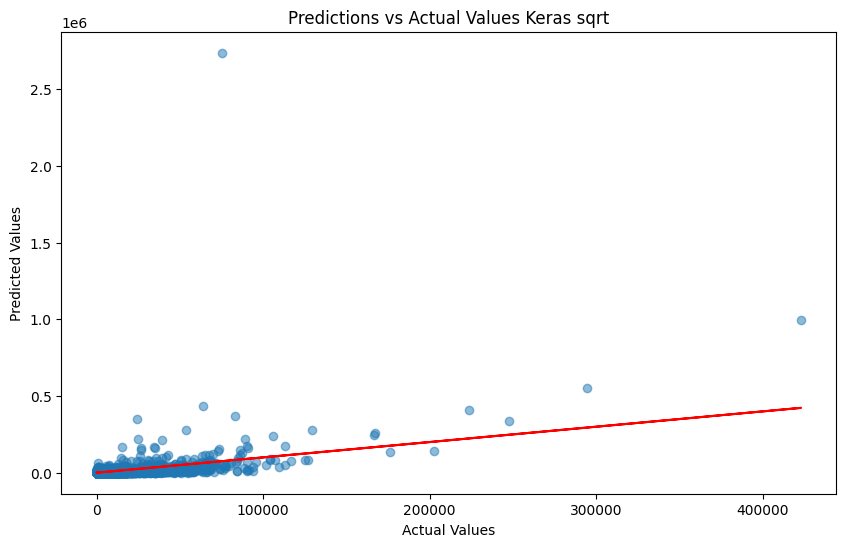

filename:./data/youtube/20240407_003133_Keras_sqrt.h5
Success


c:\Users\Jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [70]:
dict_log=function_models_log_sqrt(df,["total_viewslog"],drop_columns_log,True,False)
dict_sqrt=function_models_log_sqrt(df,["total_viewssqrt"],drop_columns_sqrt,False,True)

In [77]:
drop_columns_log

['channel_id',
 'channel_link',
 'channel_name',
 'banner_link',
 'description',
 'keywords',
 'avatar',
 'country',
 'keyword_list',
 'country_formatted',
 'join_date',
 'join_date_datetime',
 'total_viewssqrt',
 'total_views']

Visualizing real values vs model predictionns

In [80]:
df_features = df.drop([original_target]+drop_columns+['total_viewssqrt']+['total_viewslog'],axis=1)
X_train_plot, X_test_plot, y_train_plot, y_test_plot = train_test_split(df_features,#X
                                                        df[original_target].squeeze(),#Y
                                                        test_size=0.2,
                                                        random_state=42)

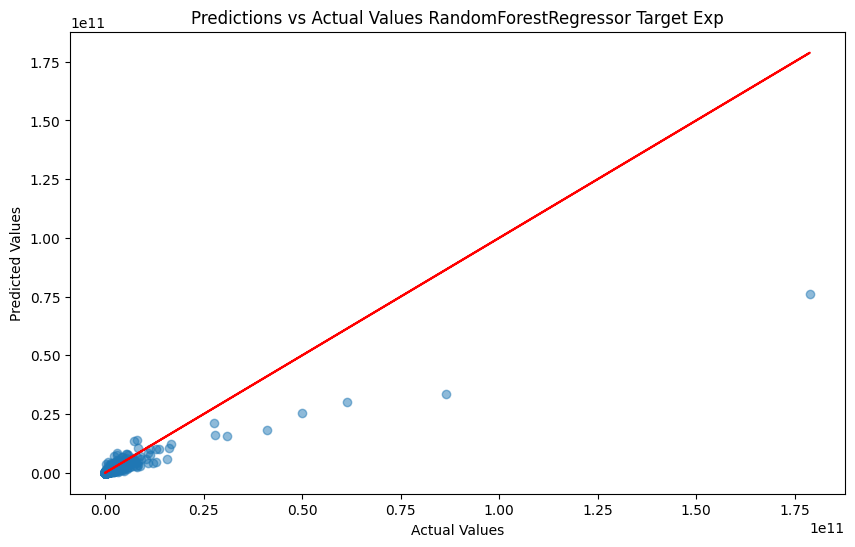

C:\Users\Jorge\AppData\Local\Temp\ipykernel_11452\3732913137.py:10: RuntimeWarning: overflow encountered in exp
  preds_exp = np.exp(model.predict(X_test_scaled_log))


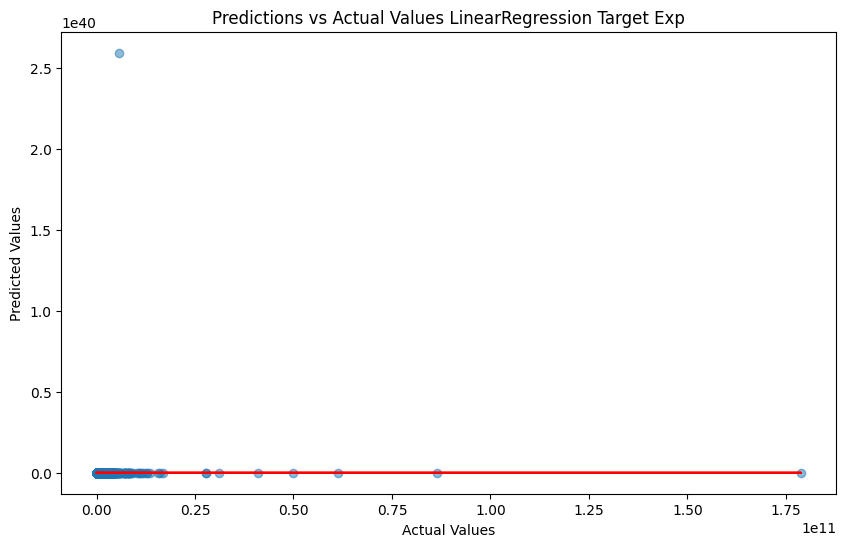

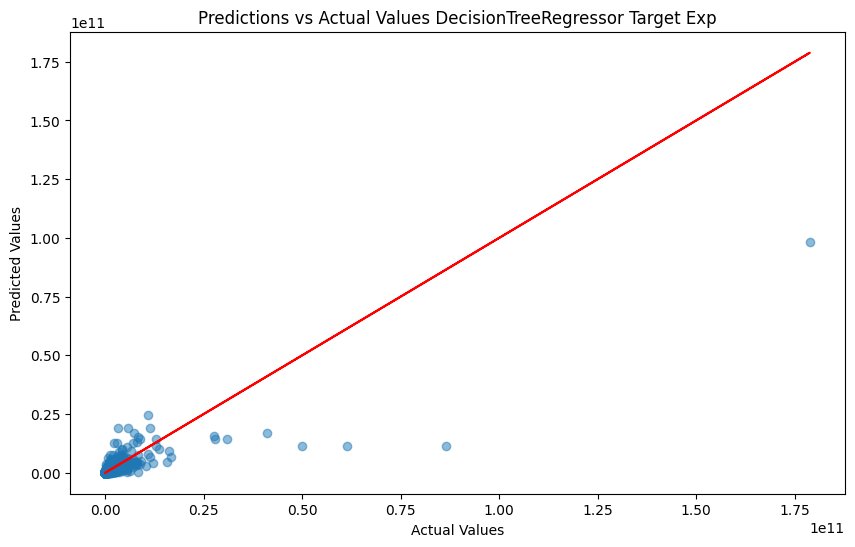

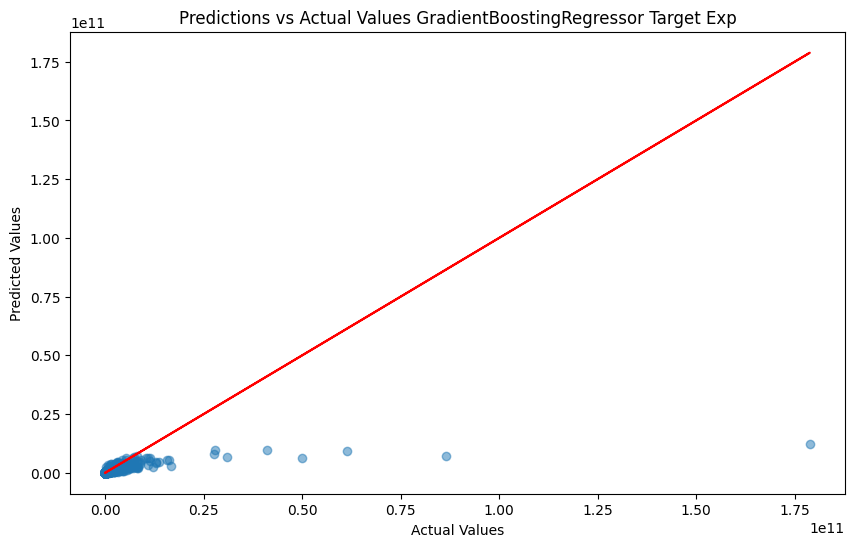

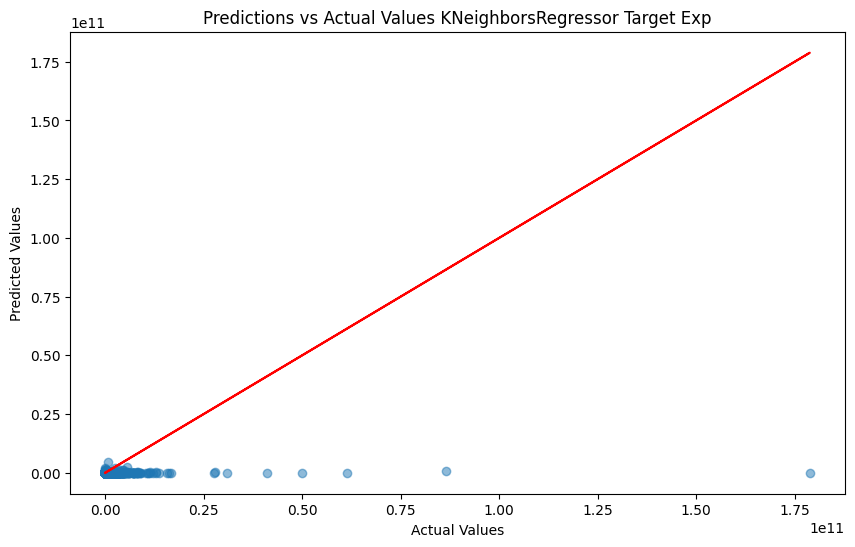

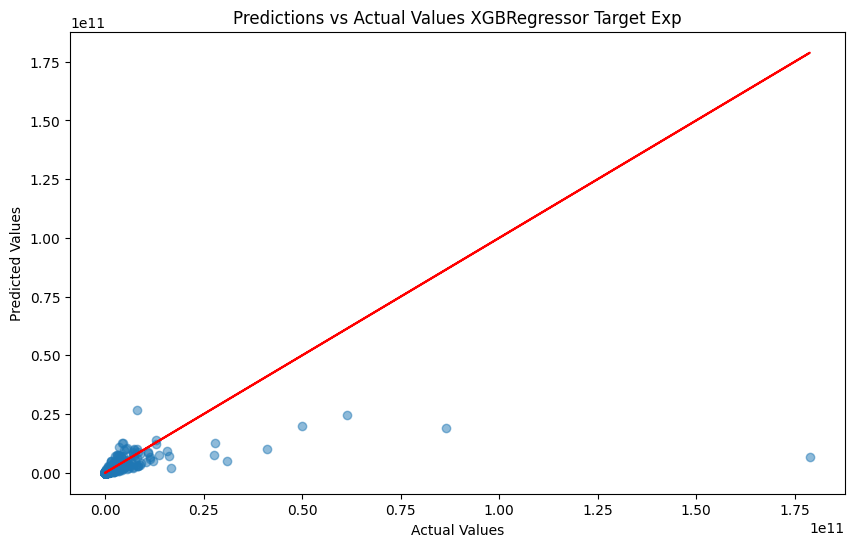

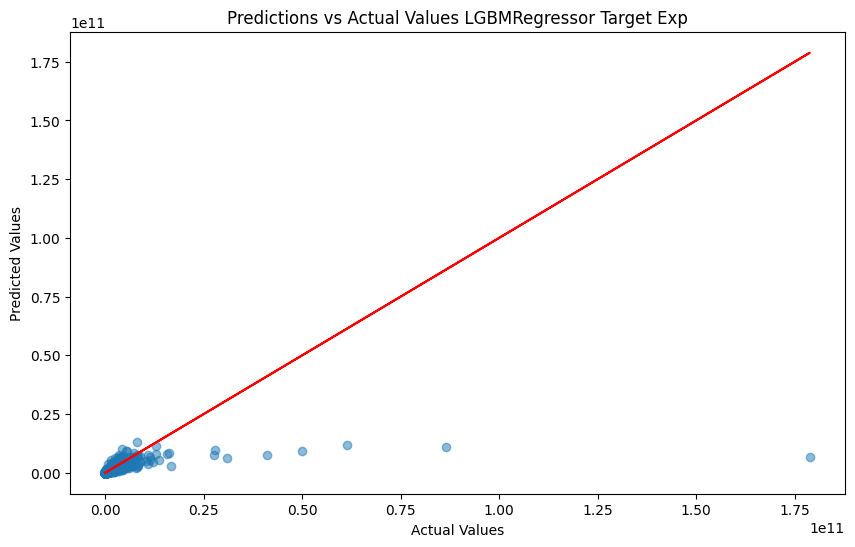

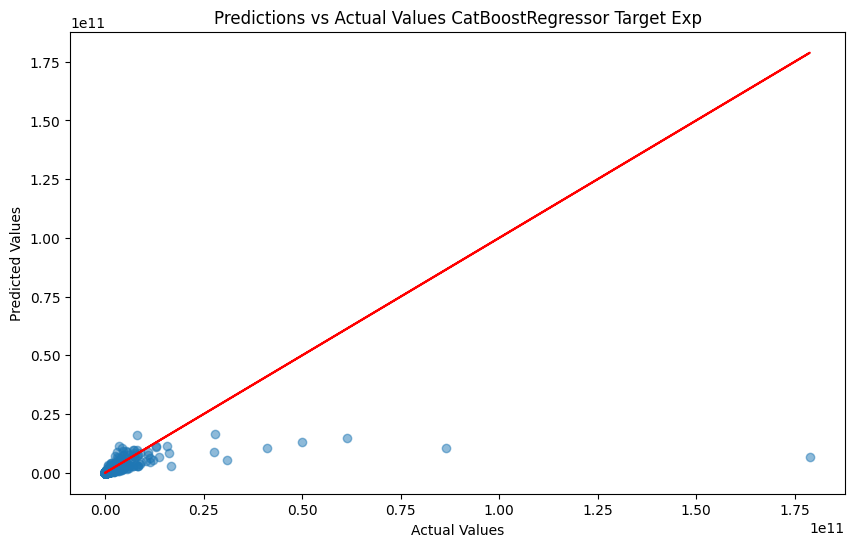

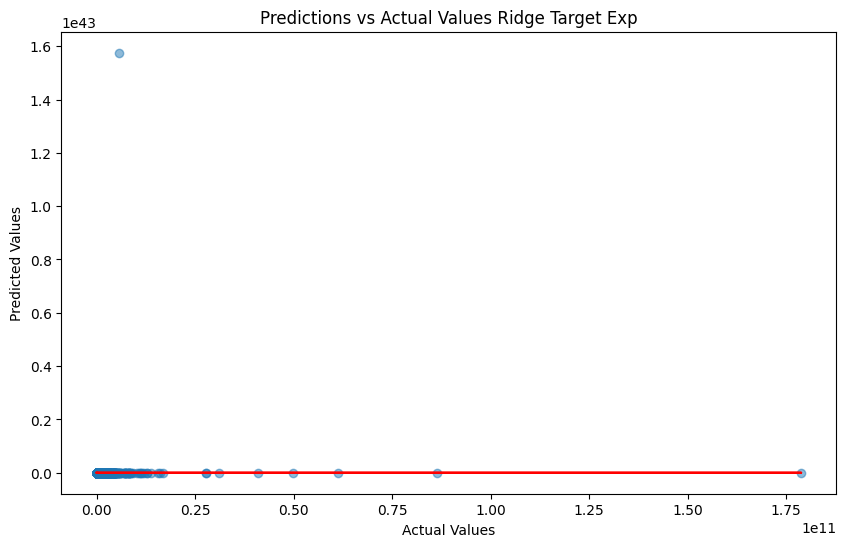

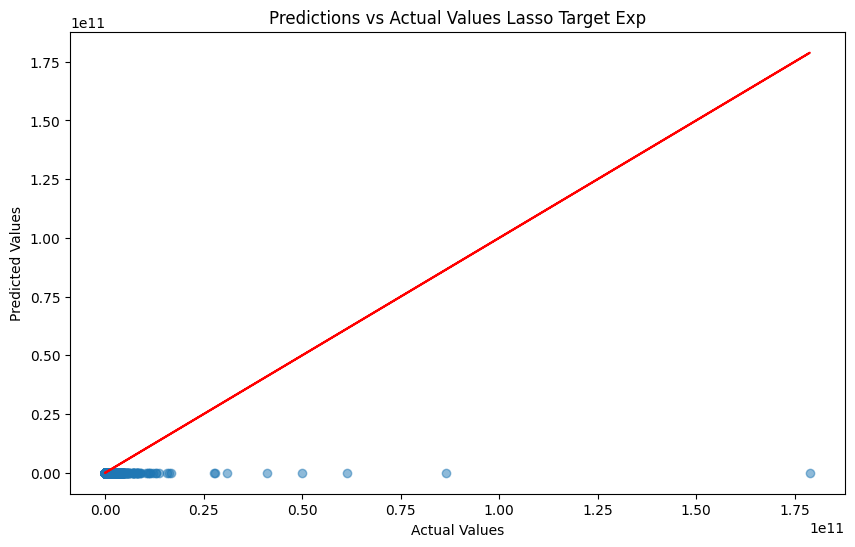

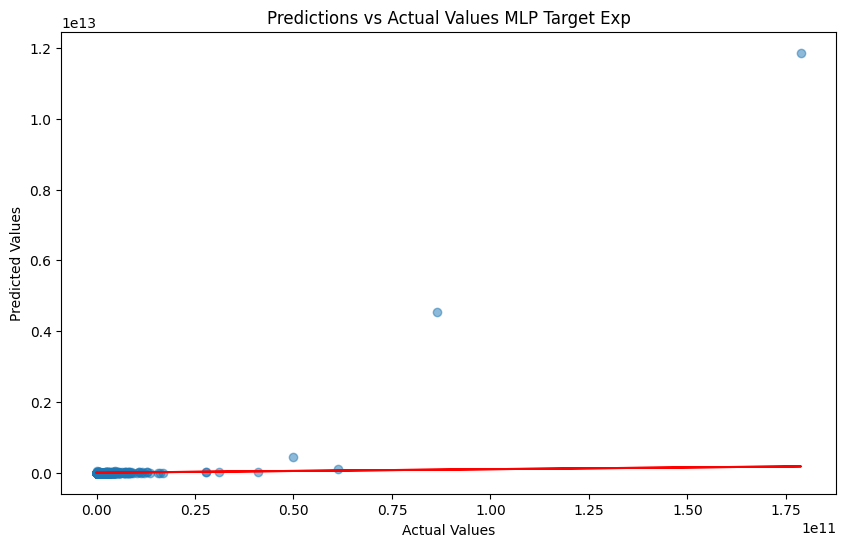

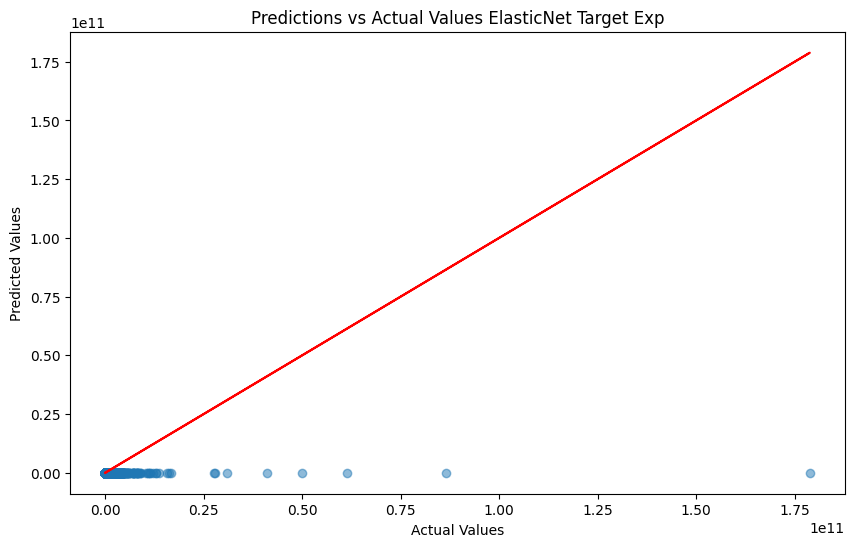

689/689 [==============================] - 1s 2ms/step


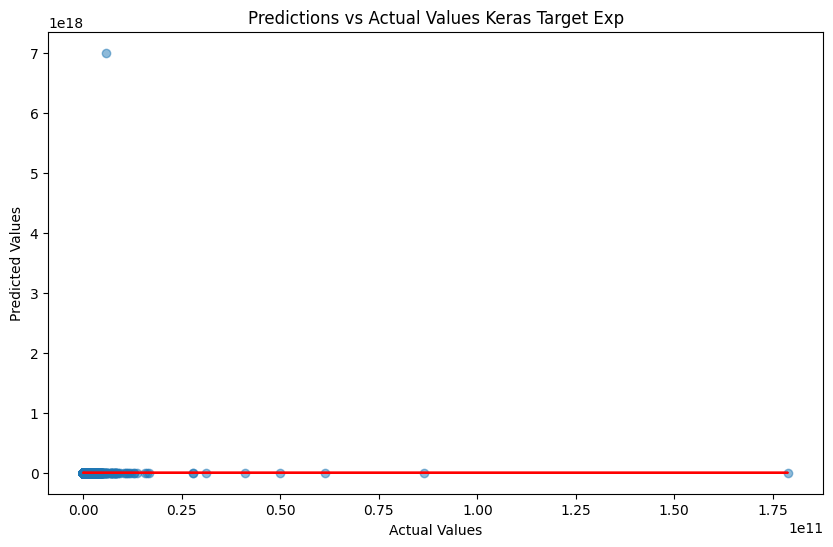

In [84]:
models_dict_log=dict_log['models']
X_train_log=dict_log['X_train']
X_test_log=dict_log['X_test']
X_train_scaled_log=dict_log['X_train_scaled']
X_test_scaled_log=dict_log['X_test_scaled']
y_train_log=dict_log['y_train']
y_test_log=dict_log['y_test']
for key,model in models_dict_log.items():
        y_test = y_test_plot
        preds_exp = np.exp(model.predict(X_test_scaled_log))
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, preds_exp, alpha=0.5)
        plt.title(f'Predictions vs Actual Values {key} Target Exp')
        plt.xlabel(f'Actual Values')
        plt.ylabel(f'Predicted Values')
        # Plot a line for perfect predictions
        plt.plot(y_test, y_test, color='red')
        plt.show()

c:\Users\Jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


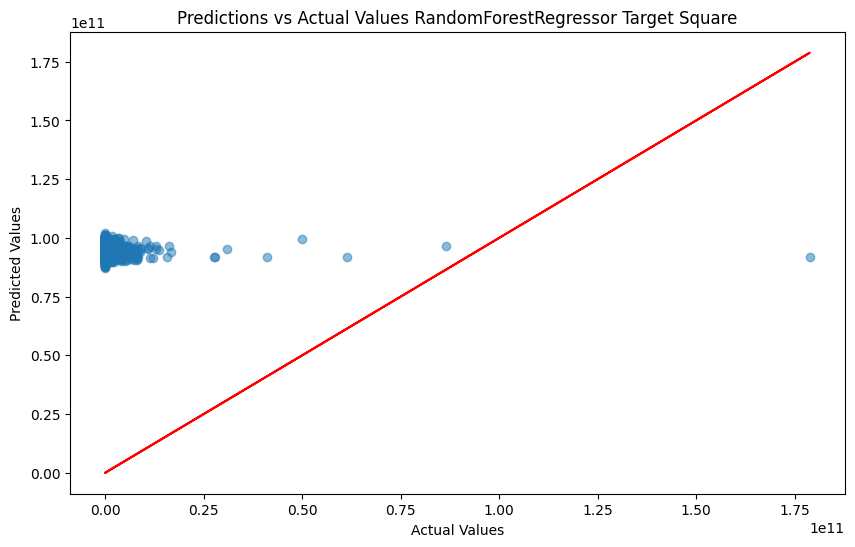

c:\Users\Jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


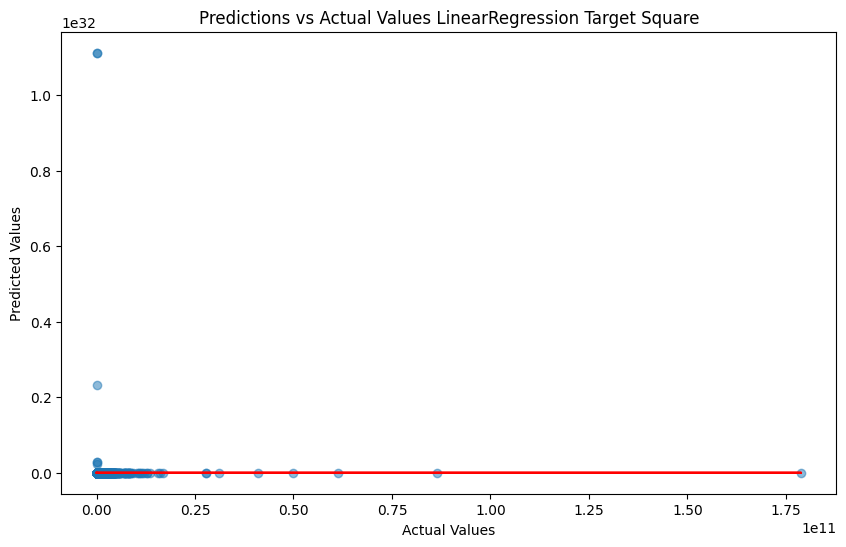

c:\Users\Jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


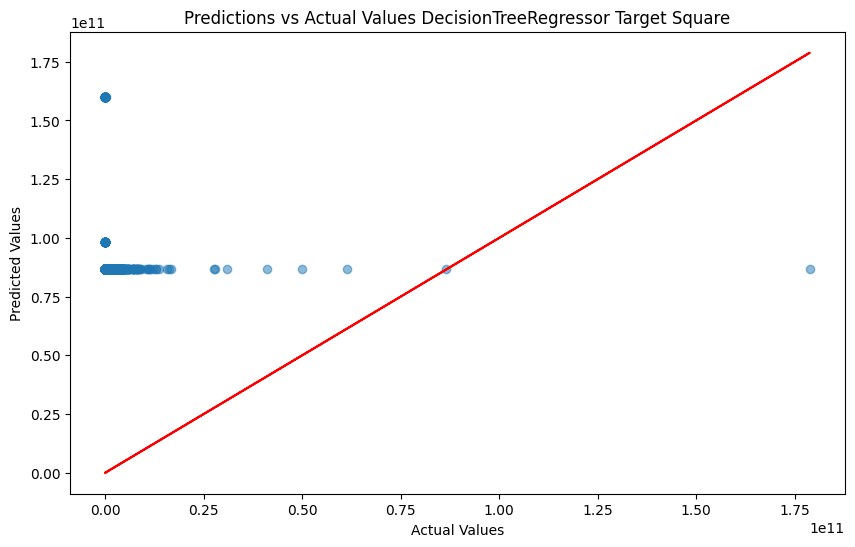

c:\Users\Jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


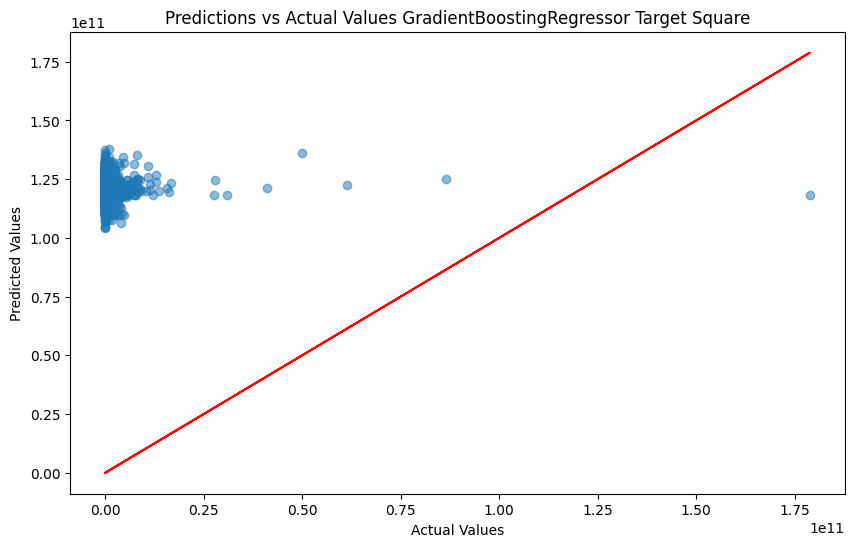

c:\Users\Jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(


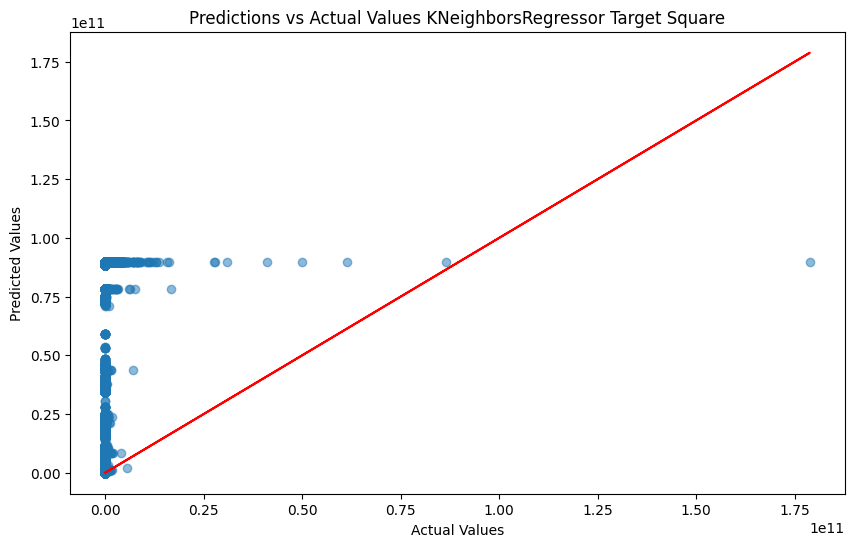

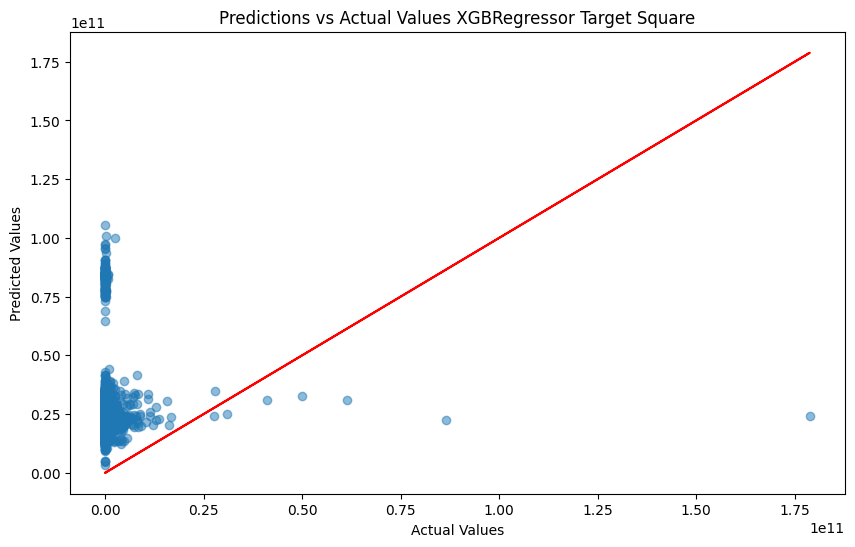

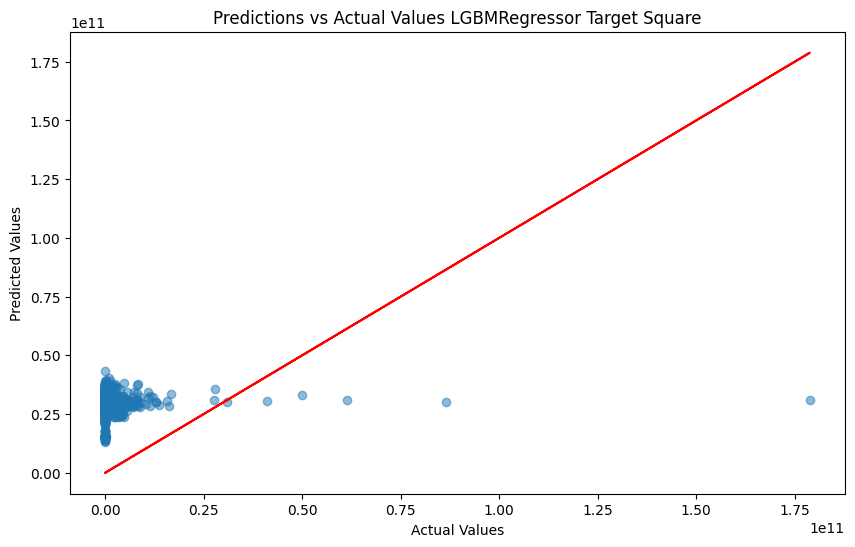

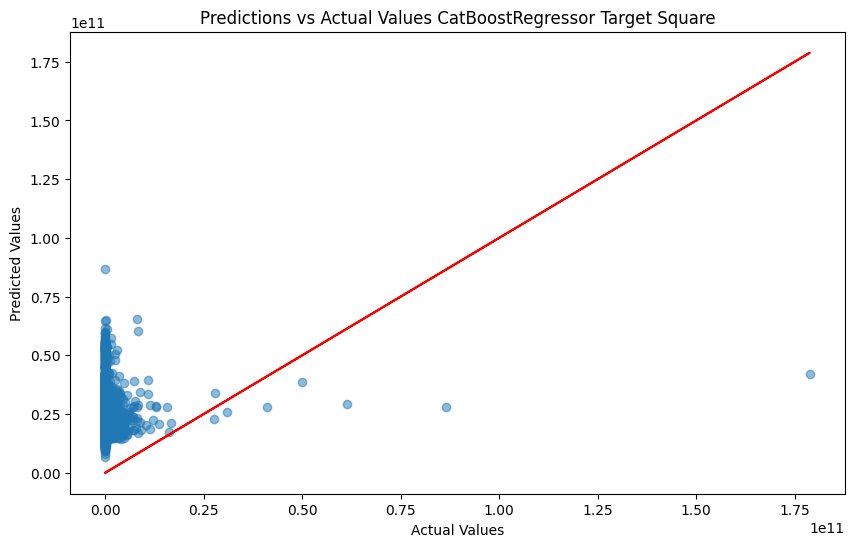

c:\Users\Jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


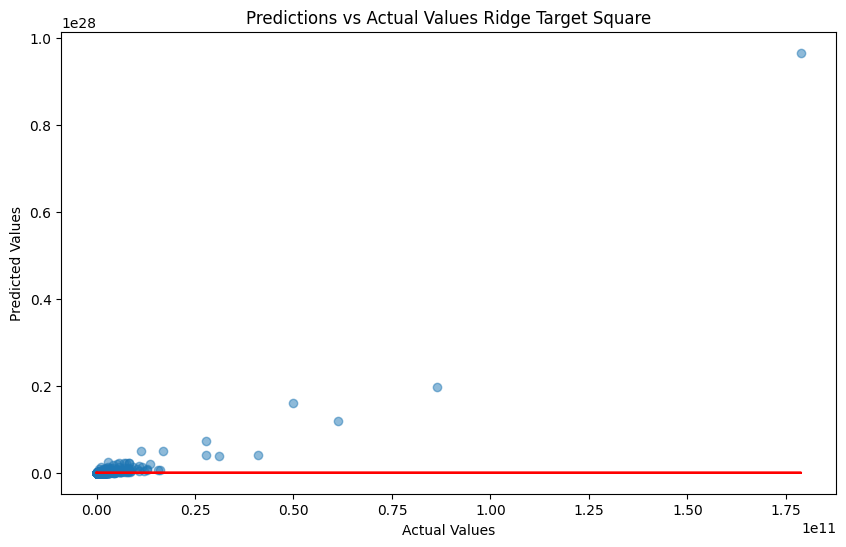

c:\Users\Jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


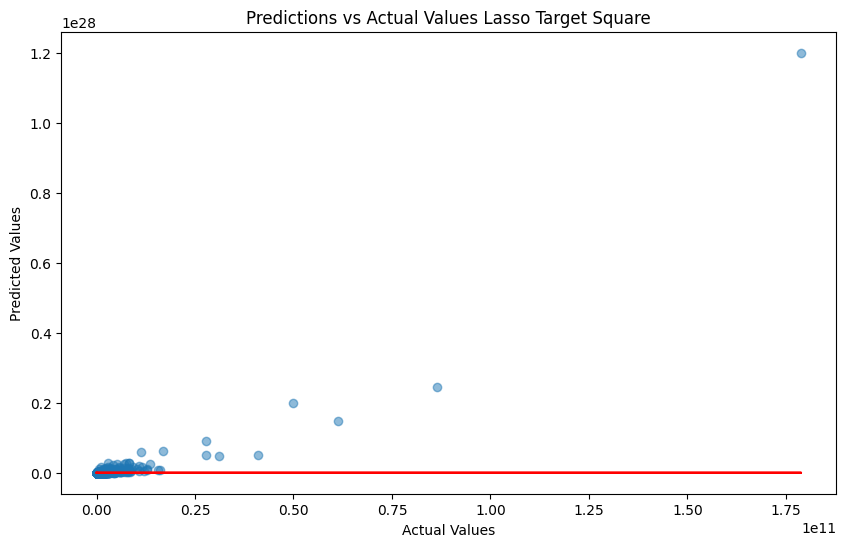

c:\Users\Jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


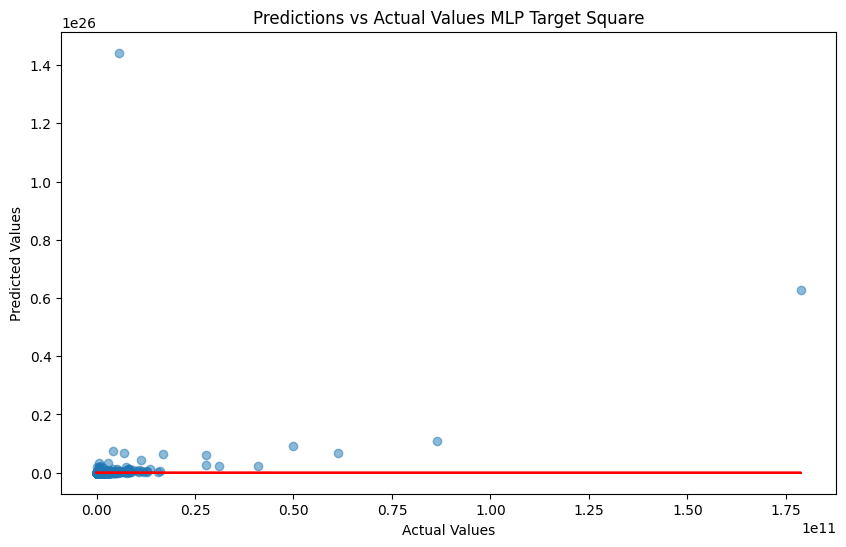

c:\Users\Jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(


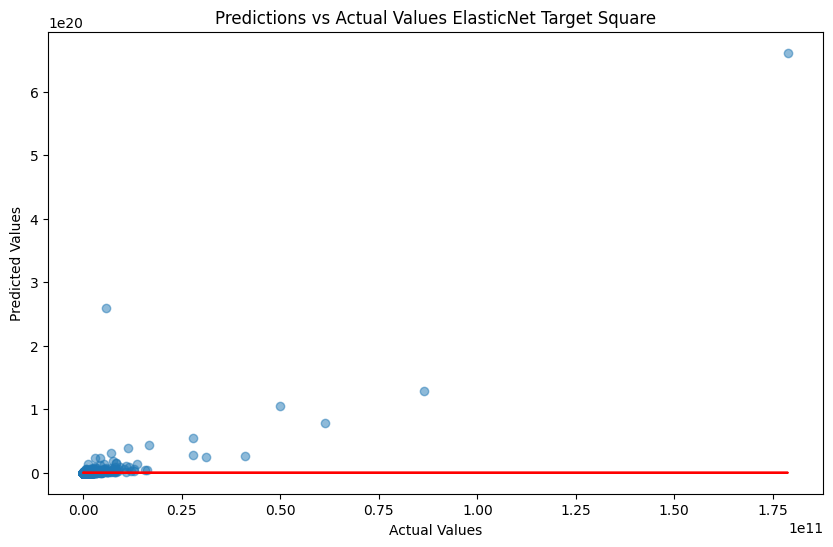

689/689 [==============================] - 1s 2ms/step


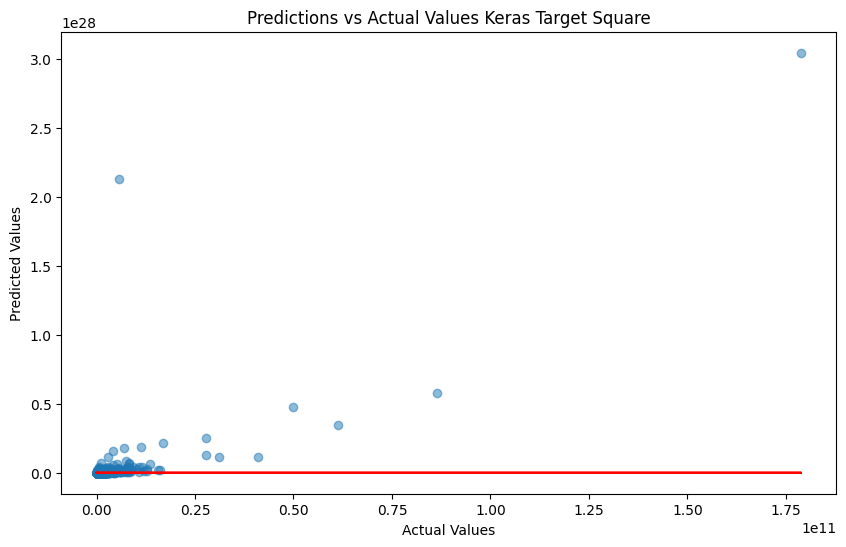

In [82]:
models_dict_sqrt=dict_sqrt['models']
X_train_sqrt=dict_sqrt['X_train']
X_test_sqrt=dict_sqrt['X_test']
X_train_scaled_sqrt=dict_sqrt['X_train_scaled']
X_test_scaled_sqrt=dict_sqrt['X_test_scaled']
y_train_sqrt=dict_sqrt['y_train']
y_test_sqrt=dict_sqrt['y_test']
for key,model in models_dict_sqrt.items():
        y_test = y_test_plot
        preds_exp = np.square(model.predict(X_test_scaled_sqrt))
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, preds_exp, alpha=0.5)
        plt.title(f'Predictions vs Actual Values {key} Target Square')
        plt.xlabel(f'Actual Values')
        plt.ylabel(f'Predicted Values')
        # Plot a line for perfect predictions
        plt.plot(y_test, y_test, color='red')
        plt.show()

c:\Users\Jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_function_transformer.py:312: RuntimeWarning: overflow encountered in expm1
  return func(X, **(kw_args if kw_args else {}))


ValueError: Input contains infinity or a value too large for dtype('float64').

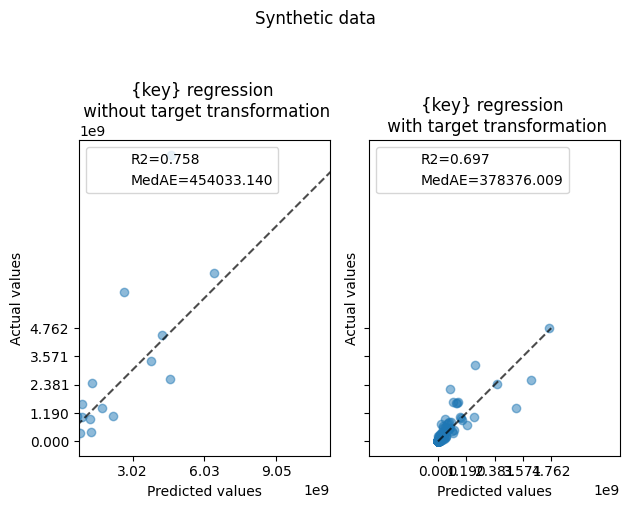

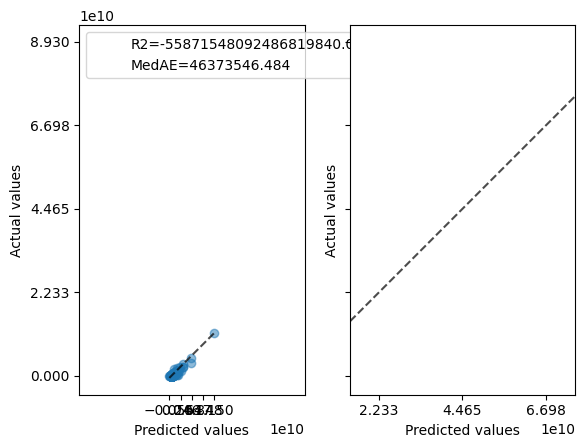

In [90]:
def compute_score(y_true, y_pred):
    return {
        "R2": f"{r2_score(y_true, y_pred):.3f}",
        "MedAE": f"{median_absolute_error(y_true, y_pred):.3f}",
    }
df_features = df.drop([original_target]+drop_columns+['total_viewssqrt']+['total_viewslog'],axis=1)
X_train_plot, X_test_plot, y_train_plot, y_test_plot = train_test_split(df_features,#X
                                                        df[original_target].squeeze(),#Y
                                                        test_size=0.2,
                                                        random_state=42)
#models_dict_log=dict_log['models']
#X_train_log=dict_log['X_train']
#X_test_log=dict_log['X_test']
#X_train_scaled_log=dict_log['X_train_scaled']
#X_test_scaled_log=dict_log['X_test_scaled']
#y_train_log=dict_log['y_train']
#y_test_log=dict_log['y_test']
rfr_model = RandomForestRegressor(random_state=42)
lr_model = LinearRegression()
dtr_model = DecisionTreeRegressor(random_state=42)
gbr_model = GradientBoostingRegressor(random_state=42)
knr_model=KNeighborsRegressor()
xgb_model=XGBRegressor(random_state=42)
lgb_model=LGBMRegressor(random_state=42,verbose=-100)
cbr_model=CatBoostRegressor(random_state=42,verbose=False)

models={'RandomForestRegressor':rfr_model,
        'LinearRegression':lr_model,
        'DecisionTreeRegressor':dtr_model,
        'GradientBoostingRegressor':gbr_model,
        'KNeighborsRegressor':knr_model,
        'XGBRegressor':xgb_model,
        'LGBMRegressor':lgb_model,
        'CatBoostRegressor':cbr_model,
        }

X_train_scaled_plot,X_test_scaled_plot=dafu.scaler_of_x_train_and_x_test(X_train_plot,X_test_plot)
for key,model in models.items():
    f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

    model_cv = model.fit(X_train_scaled_plot, y_train_plot)
    y_pred_model = model_cv.predict(X_test_scaled_plot)

    model_cv_with_trans_target = TransformedTargetRegressor(
        regressor=model, func=np.log1p, inverse_func=np.expm1
    ).fit(X_train_scaled_plot, y_train_plot)
    y_pred_model_with_trans_target = model_cv_with_trans_target.predict(X_test_scaled_plot)

    PredictionErrorDisplay.from_predictions(
        y_test_plot,
        y_pred_model,
        kind="actual_vs_predicted",
        ax=ax0,
        scatter_kwargs={"alpha": 0.5},
    )
    PredictionErrorDisplay.from_predictions(
        y_test_plot,
        y_pred_model_with_trans_target,
        kind="actual_vs_predicted",
        ax=ax1,
        scatter_kwargs={"alpha": 0.5},
    )

    # Add the score in the legend of each axis
    for ax, y_pred in zip([ax0, ax1], [y_pred_model, y_pred_model_with_trans_target]):
        for name, score in compute_score(y_test_plot, y_pred).items():
            ax.plot([], [], " ", label=f"{name}={score}")
        ax.legend(loc="upper left")

    ax0.set_title("{key} regression \n without target transformation")
    ax1.set_title("{key} regression \n with target transformation")
    f.suptitle("Synthetic data", y=1.05)
    plt.tight_layout()

NameError: name 'X_train' is not defined

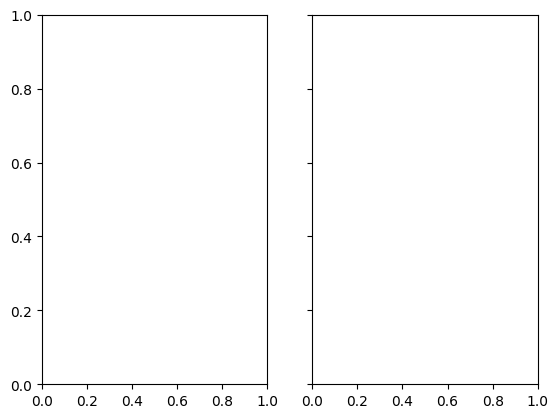

In [83]:
from sklearn.metrics import median_absolute_error, r2_score
def compute_score(y_true, y_pred):
    return {
        "R2": f"{r2_score(y_true, y_pred):.3f}",
        "MedAE": f"{median_absolute_error(y_true, y_pred):.3f}",
    }
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import PredictionErrorDisplay

f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

ridge_cv = RidgeCV().fit(X_train, y_train)
y_pred_ridge = ridge_cv.predict(X_test)

ridge_cv_with_trans_target = TransformedTargetRegressor(
    regressor=RidgeCV(), func=np.log1p, inverse_func=np.expm1
).fit(X_train, y_train)
y_pred_ridge_with_trans_target = ridge_cv_with_trans_target.predict(X_test)

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge,
    kind="actual_vs_predicted",
    ax=ax0,
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge_with_trans_target,
    kind="actual_vs_predicted",
    ax=ax1,
    scatter_kwargs={"alpha": 0.5},
)

# Add the score in the legend of each axis
for ax, y_pred in zip([ax0, ax1], [y_pred_ridge, y_pred_ridge_with_trans_target]):
    for name, score in compute_score(y_test, y_pred).items():
        ax.plot([], [], " ", label=f"{name}={score}")
    ax.legend(loc="upper left")

ax0.set_title("Ridge regression \n without target transformation")
ax1.set_title("Ridge regression \n with target transformation")
f.suptitle("Synthetic data", y=1.05)
plt.tight_layout()


RandomForestRegressor R^2 score: 0.9337
RandomForestRegressor MAE score: 0.5819
RandomForestRegressor MSE score: 0.6162
RandomForestRegressor RMSE score: 0.785
RandomForestRegressor MAPE score: 4.5476
LinearRegression R^2 score: -7.740921740669247e+21
LinearRegression MAE score: 3518491254.4596
LinearRegression MSE score: 7.193671650326789e+22
LinearRegression RMSE score: 268210209543.313
LinearRegression MAPE score: 30853379052.6044
DecisionTreeRegressor R^2 score: 0.8695
DecisionTreeRegressor MAE score: 0.8163
DecisionTreeRegressor MSE score: 1.213
DecisionTreeRegressor RMSE score: 1.1014
DecisionTreeRegressor MAPE score: 6.3529
GradientBoostingRegressor R^2 score: 0.8892
GradientBoostingRegressor MAE score: 0.7532
GradientBoostingRegressor MSE score: 1.0296
GradientBoostingRegressor RMSE score: 1.0147
GradientBoostingRegressor MAPE score: 6.1693
KNeighborsRegressor R^2 score: 0.0591
...
Lasso MAE score: 2.4107
Lasso MSE score: 9.2934
Lasso RMSE score: 3.0485
Lasso MAPE score: 19.5184
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...
c:\Users\Jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
MLP R^2 score: 0.706
MLP MAE score: 1.2455
MLP MSE score: 2.7321
MLP RMSE score: 1.6529
MLP MAPE score: 10.3889
ElasticNet R^2 score: -0.0
ElasticNet MAE score: 2.4107
ElasticNet MSE score: 9.2934
ElasticNet RMSE score: 3.0485
ElasticNet MAPE score: 19.5184
WARNING:tensorflow:From c:\Users\Jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\tf_utils.py:492: The name tf.ragged.RaggedTensorValue is deprecated. Please use tf.compat.v1.ragged.RaggedTensorValue instead.

2753/2753 [==============================] - 23s 8ms/step - loss: 21.9395
689/689 [==============================] - 1s 2ms/step
Keras R^2 score: -0.0766
Keras MAE score: 2.5246
Keras MSE score: 10.0045
Keras RMSE score: 3.163
Keras MAPE score: 22.7177
Success
RandomForestRegressor R^2 score: 0.9023
RandomForestRegressor MAE score: 909.2593
RandomForestRegressor MSE score: 8313087.1673
RandomForestRegressor RMSE score: 2883.2425
RandomForestRegressor MAPE score: 35.5129
...
Lasso MAE score: 2483.2891
Lasso MSE score: 23351178.4857
Lasso RMSE score: 4832.3057
Lasso MAPE score: 499.4646
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...
c:\Users\Jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
MLP R^2 score: 0.3742
MLP MAE score: 3310.8328
MLP MSE score: 53270105.5016
MLP RMSE score: 7298.6372
MLP MAPE score: 650.6716
ElasticNet R^2 score: 0.0159
ElasticNet MAE score: 4007.6265
ElasticNet MSE score: 83763249.3539
ElasticNet RMSE score: 9152.2265
ElasticNet MAPE score: 1000.1379
2753/2753 [==============================] - 21s 8ms/step - loss: 59807188.0000
689/689 [==============================] - 1s 1ms/step
Keras R^2 score: -3.4615
Keras MAE score: 3102.701
Keras MSE score: 379749087.7776
Keras RMSE score: 19487.1519
Keras MAPE score: 940.5156
Success
RandomForestRegressor R^2 score: 0.9337
RandomForestRegressor MAE score: 0.5819
RandomForestRegressor MSE score: 0.6162
RandomForestRegressor RMSE score: 0.785
RandomForestRegressor MAPE score: 4.5476
filename:./data/youtube/20240406_203426_RandomForestRegressor_log.pkl
LinearRegression R^2 score: -7.740921740669247e+21
LinearRegression MAE score: 3518491254.4596
LinearRegression MSE score: 7.193671650326789e+22
LinearRegression RMSE score: 268210209543.313
LinearRegression MAPE score: 30853379052.6044
filename:./data/youtube/20240406_203429_LinearRegression_log.pkl
DecisionTreeRegressor R^2 score: 0.8695
DecisionTreeRegressor MAE score: 0.8163
DecisionTreeRegressor MSE score: 1.213
DecisionTreeRegressor RMSE score: 1.1014
DecisionTreeRegressor MAPE score: 6.3529
filename:./data/youtube/20240406_203438_DecisionTreeRegressor_log.pkl
GradientBoostingRegressor R^2 score: 0.8892
GradientBoostingRegressor MAE score: 0.7532
GradientBoostingRegressor MSE score: 1.0296
GradientBoostingRegressor RMSE score: 1.0147
GradientBoostingRegressor MAPE score: 6.1693
filename:./data/youtube/20240406_203535_GradientBoostingRegressor_log.pkl
KNeighborsRegressor R^2 score: 0.0591
KNeighborsRegressor MAE score: 2.3252
KNeighborsRegressor MSE score: 8.7441
KNeighborsRegressor RMSE score: 2.957
KNeighborsRegressor MAPE score: 18.6684
filename:./data/youtube/20240406_203554_KNeighborsRegressor_log.pkl
XGBRegressor R^2 score: 0.9378
XGBRegressor MAE score: 0.5631
XGBRegressor MSE score: 0.5779
XGBRegressor RMSE score: 0.7602
XGBRegressor MAPE score: 4.3952
filename:./data/youtube/20240406_203556_XGBRegressor_log.pkl
LGBMRegressor R^2 score: 0.9386
LGBMRegressor MAE score: 0.5606
LGBMRegressor MSE score: 0.5706
LGBMRegressor RMSE score: 0.7554
LGBMRegressor MAPE score: 4.3775
filename:./data/youtube/20240406_203557_LGBMRegressor_log.pkl
CatBoostRegressor R^2 score: 0.9411
CatBoostRegressor MAE score: 0.5458
CatBoostRegressor MSE score: 0.5473
CatBoostRegressor RMSE score: 0.7398
CatBoostRegressor MAPE score: 4.2517
filename:./data/youtube/20240406_203610_CatBoostRegressor_log.pkl
Ridge R^2 score: 0.2548
Ridge MAE score: 2.0275
Ridge MSE score: 6.9248
Ridge RMSE score: 2.6315
Ridge MAPE score: 16.4339
filename:./data/youtube/20240406_203611_Ridge_log.pkl
Lasso R^2 score: -0.0
Lasso MAE score: 2.4107
Lasso MSE score: 9.2934
Lasso RMSE score: 3.0485
Lasso MAPE score: 19.5184
filename:./data/youtube/20240406_203611_Lasso_log.pkl
c:\Users\Jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
MLP R^2 score: 0.6789
MLP MAE score: 1.3017
MLP MSE score: 2.9841
MLP RMSE score: 1.7275
MLP MAPE score: 10.8995
filename:./data/youtube/20240406_205425_MLP_log.pkl
ElasticNet R^2 score: -0.0
ElasticNet MAE score: 2.4107
ElasticNet MSE score: 9.2934
ElasticNet RMSE score: 3.0485
ElasticNet MAPE score: 19.5184
filename:./data/youtube/20240406_205425_ElasticNet_log.pkl
2753/2753 [==============================] - 21s 7ms/step - loss: 22.1184
689/689 [==============================] - 1s 2ms/step
Keras R^2 score: -0.0028
Keras MAE score: 2.4256
Keras MSE score: 9.3192
Keras RMSE score: 3.0527
Keras MAPE score: 22.3435
c:\Users\Jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
filename:./data/youtube/20240406_205454_Keras_log.h5
Success
RandomForestRegressor R^2 score: 0.9023
RandomForestRegressor MAE score: 909.2593
RandomForestRegressor MSE score: 8313087.1673
RandomForestRegressor RMSE score: 2883.2425
RandomForestRegressor MAPE score: 35.5129
filename:./data/youtube/20240406_210512_RandomForestRegressor_sqrt.pkl
LinearRegression R^2 score: -1.35323740096438e+20
LinearRegression MAE score: 1407913910341.6597
LinearRegression MSE score: 1.1518339039845173e+28
LinearRegression RMSE score: 107323525099789.62
LinearRegression MAPE score: 621338698568.3645
filename:./data/youtube/20240406_210515_LinearRegression_sqrt.pkl
DecisionTreeRegressor R^2 score: 0.8038
DecisionTreeRegressor MAE score: 1263.1954
DecisionTreeRegressor MSE score: 16701590.5906
DecisionTreeRegressor RMSE score: 4086.758
DecisionTreeRegressor MAPE score: 46.2504
filename:./data/youtube/20240406_210525_DecisionTreeRegressor_sqrt.pkl
GradientBoostingRegressor R^2 score: 0.9147
GradientBoostingRegressor MAE score: 1014.0338
GradientBoostingRegressor MSE score: 7259519.5198
GradientBoostingRegressor RMSE score: 2694.3496
GradientBoostingRegressor MAPE score: 95.183
filename:./data/youtube/20240406_210620_GradientBoostingRegressor_sqrt.pkl
KNeighborsRegressor R^2 score: 0.0398
KNeighborsRegressor MAE score: 3827.7414
KNeighborsRegressor MSE score: 81726906.9554
KNeighborsRegressor RMSE score: 9040.2935
KNeighborsRegressor MAPE score: 691.2129
filename:./data/youtube/20240406_210639_KNeighborsRegressor_sqrt.pkl
XGBRegressor R^2 score: 0.8207
XGBRegressor MAE score: 944.3725
XGBRegressor MSE score: 15264010.3688
XGBRegressor RMSE score: 3906.9183
XGBRegressor MAPE score: 51.0799
filename:./data/youtube/20240406_210641_XGBRegressor_sqrt.pkl
LGBMRegressor R^2 score: 0.8409
LGBMRegressor MAE score: 941.4708
LGBMRegressor MSE score: 13538095.1998
LGBMRegressor RMSE score: 3679.4151
LGBMRegressor MAPE score: 51.9535
filename:./data/youtube/20240406_210642_LGBMRegressor_sqrt.pkl
CatBoostRegressor R^2 score: 0.8321
CatBoostRegressor MAE score: 930.8357
CatBoostRegressor MSE score: 14288923.2177
CatBoostRegressor RMSE score: 3780.0692
CatBoostRegressor MAPE score: 51.4036
filename:./data/youtube/20240406_210654_CatBoostRegressor_sqrt.pkl
Ridge R^2 score: 0.7113
Ridge MAE score: 2589.9908
Ridge MSE score: 24577161.6593
Ridge RMSE score: 4957.5358
Ridge MAPE score: 528.1473
filename:./data/youtube/20240406_210655_Ridge_sqrt.pkl
Lasso R^2 score: 0.7257
Lasso MAE score: 2483.2891
Lasso MSE score: 23351178.4857
Lasso RMSE score: 4832.3057
Lasso MAPE score: 499.4646
filename:./data/youtube/20240406_210658_Lasso_sqrt.pkl
c:\Users\Jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
MLP R^2 score: 0.3587
MLP MAE score: 3319.2272
MLP MSE score: 54588080.4793
MLP RMSE score: 7388.3747
MLP MAPE score: 643.2134
filename:./data/youtube/20240406_212150_MLP_sqrt.pkl
ElasticNet R^2 score: 0.0159
ElasticNet MAE score: 4007.6265
ElasticNet MSE score: 83763249.3539
ElasticNet RMSE score: 9152.2265
ElasticNet MAPE score: 1000.1379
filename:./data/youtube/20240406_212151_ElasticNet_sqrt.pkl
2753/2753 [==============================] - 20s 7ms/step - loss: 58523816.0000
689/689 [==============================] - 1s 2ms/step
Keras R^2 score: -9.2741
Keras MAE score: 3319.8016
Keras MSE score: 874495942.6635
Keras RMSE score: 29571.8776
Keras MAPE score: 1098.4624
filename:./data/youtube/20240406_212220_Keras_sqrt.h5
Success
c:\Users\Jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(

Plot predictions vs y_test

**Results from the console**

RandomForestRegressor R^2 score: 0.7069

RandomForestRegressor MAE score: 121921524.737

RandomForestRegressor MSE score: 7.377422607937807e+17

RandomForestRegressor RMSE score: 858919239.9718

LinearRegression R^2 score: -44.9772

LinearRegression MAE score: 409871286.4686

LinearRegression MSE score: 1.1571231184128031e+20

LinearRegression RMSE score: 10756965735.8049

DecisionTreeRegressor R^2 score: 0.72

DecisionTreeRegressor MAE score: 135399015.1578

DecisionTreeRegressor MSE score: 7.047468718670682e+17

DecisionTreeRegressor RMSE score: 839492032.045

GradientBoostingRegressor R^2 score: 0.7268

GradientBoostingRegressor MAE score: 115133800.2368

GradientBoostingRegressor MSE score: 6.876670441882656e+17

GradientBoostingRegressor RMSE score: 829256922.9064

KNeighborsRegressor R^2 score: 0.6764

KNeighborsRegressor MAE score: 102363129.9931

KNeighborsRegressor MSE score: 8.143396061543904e+17

KNeighborsRegressor RMSE score: 902407671.8171

**XGBRegressor R^2 score: 0.8174**

**XGBRegressor MAE score: 120874729.5308**

**XGBRegressor MSE score: 4.5947884736360205e+17**

**XGBRegressor RMSE score: 677848690.6114**

LGBMRegressor R^2 score: 0.7136

LGBMRegressor MAE score: 108920601.08

LGBMRegressor MSE score: 7.207921126417408e+17

LGBMRegressor RMSE score: 848994765.9684

CatBoostRegressor R^2 score: 0.7906

CatBoostRegressor MAE score: 99771952.6024

CatBoostRegressor MSE score: 5.270929551011002e+17

CatBoostRegressor RMSE score: 726011676.973

Ridge R^2 score: -43.251

Ridge MAE score: 405918369.492

Ridge MSE score: 1.113678157046168e+20

Ridge RMSE score: 10553095077.0197

c:\Users\AMD\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.850e+22, tolerance: 1.102e+19
  model = cd_fast.enet_coordinate_descent(

Lasso R^2 score: -26.7667

Lasso MAE score: 355355201.4676

Lasso MSE score: 6.988138958861078e+19

Lasso RMSE score: 8359508932.2646

c:\Users\AMD\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(

MLP R^2 score: -0.0031

MLP MAE score: 97724081.2439

MLP MSE score: 2.5244503650383293e+18

MLP RMSE score: 1588851901.5435

ElasticNet R^2 score: 0.4896

ElasticNet MAE score: 174337811.2095

ElasticNet MSE score: 1.2844418406619087e+18

ElasticNet RMSE score: 1133332184.6052

2753/2753 [==============================] - 11s 3ms/step - loss: 1258811346309349376.0000

689/689 [==============================] - 6s 1ms/step

Keras R^2 score: 0.0041

Keras MAE score: 96871182.0764

Keras MSE score: 2.5065224678104873e+18

Keras RMSE score: 1583200071.9462


In [37]:
df_describe = pd.DataFrame(df[target].describe())
df_describe['mae_score']=0.0
df_describe.at["mean",'mae_score']=120874729.5308
df_describe.at["mean",'mae_score_percentage']=df_describe.loc["mean"]['mae_score']/df_describe.loc["mean"]['total_views']



In [38]:
df_describe

total_views     mae_score  mae_score_percentage
count  1.158960e+05  0.000000e+00                   NaN
mean   8.833637e+07  1.208747e+08              1.368346
std    1.196010e+09  0.000000e+00                   NaN
min    1.000000e+00  0.000000e+00                   NaN
25%    1.433678e+05  0.000000e+00                   NaN
50%    8.391330e+05  0.000000e+00                   NaN
75%    8.168781e+06  0.000000e+00                   NaN
max    1.788442e+11  0.000000e+00                   NaN

In [29]:
df_describe

total_views  mae_score
count  1.158960e+05          0
mean   8.833637e+07          0
std    1.196010e+09          0
min    1.000000e+00          0
25%    1.433678e+05          0
50%    8.391330e+05          0
75%    8.168781e+06          0
max    1.788442e+11          0

Saving the best model

In [ ]:
xgb_model.save_model(f'./data/youtube/{tb.datetime_naming_convention()}_xgb_model.json')


Loading the best model

In [ ]:
xgb_model.load_model("./data/youtube/20240322_0701_xgb_model.json")

Attempt with GridSearchCV and RandomSearchCV of improving the model

With GridSearchCV

In [ ]:
param_grid={
    'learning_rate':[0.1],
    'n_estimators':[1000],
    'max_depth':[3,5,8,10],
    'min_child_weight':[1],
    'gamma':[0.1,0.2],    
    'subsample':[0.8],
    'colsample_bytree':[0.5,0.9],
    'nthread':[4],
    'scale_pos_weight':[1]
}
list_df_metrics=[]
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
# Fit GridSearchCV
grid_search.fit(X_train, y_train)  # Assuming X_train and y_train are your data

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
preds = grid_search.predict(X_test)
# Metrics
print(f"{key} R^2 score:", round(r2_score(y_test, preds), 4))
print(f"{key} MAE score:", round(mean_absolute_error(y_test, preds), 4))
print(f"{key} MSE score:", round(mean_squared_error(y_test, preds), 4))
print(f"{key} RMSE score:", round(np.sqrt(mean_squared_error(y_test, preds)), 4))
print(f"{key} MAPE score:", round(tb.mean_absolute_percentage_error(y_test, preds), 4))
list_df_metrics.append(tb.arima_metrics(y_test,'grid_search_xgb',"","",preds))
df_metrics=pd.concat(list_df_metrics, ignore_index=True)

With RandomSearchCV

In [ ]:
param_grid={
    'learning_rate':[0.1],
    'n_estimators':[1000],
    'max_depth':[3,5,8,10],
    'min_child_weight':[1],
    'gamma':[0.1,0.2],    
    'subsample':[0.8],
    'colsample_bytree':[0.5,0.9],
    'nthread':[4],
    'scale_pos_weight':[1]
}
random_search = RandomizedSearchCV(xgb_model, param_grid, n_iter=50, scoring='neg_mean_squared_error', cv=3, verbose=1, random_state=42)

# Fit GridSearchCV
random_search.fit(X_train, y_train)  # Assuming X_train and y_train are your data

# Best parameters and best score
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)
preds = random_search.predict(X_test)
# Metrics
print(f"{key} R^2 score:", round(r2_score(y_test, preds), 4))
print(f"{key} MAE score:", round(mean_absolute_error(y_test, preds), 4))
print(f"{key} MSE score:", round(mean_squared_error(y_test, preds), 4))
print(f"{key} RMSE score:", round(np.sqrt(mean_squared_error(y_test, preds)), 4))
print(f"{key} MAPE score:", round(tb.mean_absolute_percentage_error(y_test, preds), 4))
list_df_metrics.append(tb.arima_metrics(y_test,'random_search_xgb',"","",preds))
df_metrics=pd.concat(list_df_metrics, ignore_index=True)

Building metrics DataFrame for RandomSearch and GridSearch 

In [ ]:
df_metrics=pd.concat(list_df_metrics, ignore_index=True)


In [ ]:
df_metrics

Saving DataFrame

In [ ]:
df_metrics.to_csv(f'./data/youtube/{tb.datetime_naming_convention()}_randomsearch_gridsearch_metrics.csv')

Saving both models

In [ ]:
partial_filename= f'./data/youtube/{tb.datetime_naming_convention()}'
# Save the GridSearchCV or RandomizedSearchCV object
with open(f'{partial_filename}_grid_search_xgb.pkl', 'wb') as file:
    pickle.dump(grid_search, file)  # Change 'grid_search' to 'random_search' if needed
with open(f'{partial_filename}_random_search_xgb.pkl', 'wb') as file:
    pickle.dump(grid_search, file)  # Change 'grid_search' to 'random_search' if needed

**Step 8: Model comparison**

Graphical comparison of metrics

Outliers

Fit

param_grid


Powerpoint

Tell the story

With data

MiniEDA

Correlation 

Model Results comparison

Comparative graph

Check against test

**Step 8:**

**Step 9:**

**Step 10:**

**Step 11:**

**Step 12: How to get keywords DataFrame**

In [ ]:
keywords_list=[]
keywords_dict={}
for index,row in df.iterrows():
    keywords=row['keywords'].split(",")
    for keyword in keywords:
        if dafu.is_english(keyword):
            keyword= keyword.lower()
            keyword= keyword.replace(' ', '_')
            if keyword not in keywords_list:
                keywords_list.append(keyword)
                keywords_dict[keyword]=1
            else:
                keywords_dict[keyword]=keywords_dict[keyword]+1

# Convert the dictionary to a DataFrame
keywords_df = pd.DataFrame.from_dict(keywords_dict, orient='index', columns=['Count'])

# Reset the index to make the keywords a column
keywords_df.reset_index(inplace=True)
keywords_df.rename(columns={'index': 'Keyword'}, inplace=True)
#keywords_df.to_csv('./data/youtube/youtube_chanels_1M_clean_keywords.csv',index=False)